In [252]:
import numpy as np
import pandas as pd
import os
import openpyxl
import xlsxwriter
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.special import ndtr as ndtr
from scipy import stats
from scipy.stats import norm
from scipy.stats import anderson
from openpyxl import load_workbook
from IPython.display import Image
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 2000)
pd.set_option('max_colwidth', 20)

In [253]:
url = 'https://github.com/JanCinis/co2-emissions-analysis/blob/main/owid-co2-data.csv?raw=true'
df = pd.read_csv(url)
print(df.info(5))   # dataset preview
df.head()           # dataset summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 58 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   iso_code                             21948 non-null  object 
 1   country                              25204 non-null  object 
 2   year                                 25204 non-null  int64  
 3   co2                                  23949 non-null  float64
 4   consumption_co2                      3976 non-null   float64
 5   co2_growth_prct                      24931 non-null  float64
 6   co2_growth_abs                       23585 non-null  float64
 7   trade_co2                            3976 non-null   float64
 8   co2_per_capita                       23307 non-null  float64
 9   consumption_co2_per_capita           3976 non-null   float64
 10  share_global_co2                     23949 non-null  float64
 11  cumulative_co2              

iso_code      country  year    co2  consumption_co2  co2_growth_prct  \
0      AFG  Afghanistan  1949  0.015              NaN              NaN   
1      AFG  Afghanistan  1950  0.084              NaN            475.0   
2      AFG  Afghanistan  1951  0.092              NaN              8.7   
3      AFG  Afghanistan  1952  0.092              NaN              0.0   
4      AFG  Afghanistan  1953  0.106              NaN             16.0   

   co2_growth_abs  trade_co2  co2_per_capita  consumption_co2_per_capita  \
0             NaN        NaN           0.002                  NaN          
1           0.070        NaN           0.011                  NaN          
2           0.007        NaN           0.012                  NaN          
3           0.000        NaN           0.012                  NaN          
4           0.015        NaN           0.013                  NaN          

   share_global_co2  cumulative_co2  share_global_cumulative_co2  co2_per_gdp  \
0               0.0           0.015                  0.0                  NaN   
1               0.0           0.099                  0.0                0.009   
2               0.0           0.191                  0.0                0.010   
3               0.0           0.282                  0.0                0.009   
4               0.0           0.388                  0.0                0.010   

   consumption_co2_per_gdp  co2_per_unit_energy  coal_co2  cement_co2  \
0                  NaN                      NaN     0.015         NaN   
1                  NaN                      NaN     0.021         NaN   
2                  NaN                      NaN     0.026         NaN   
3                  NaN                      NaN     0.032         NaN   
4                  NaN                      NaN     0.038         NaN   

   flaring_co2  gas_co2  oil_co2  other_industry_co2  cement_co2_per_capita  \
0          NaN      NaN      NaN                 NaN                  NaN     
1          NaN      NaN    0.063                 NaN                  NaN     
2          NaN      NaN    0.066                 NaN                  NaN     
3          NaN      NaN    0.060                 NaN                  NaN     
4          NaN      NaN    0.068                 NaN                  NaN     

   coal_co2_per_capita  flaring_co2_per_capita  gas_co2_per_capita  \
0                0.002                  NaN                    NaN   
1                0.003                  NaN                    NaN   
2                0.003                  NaN                    NaN   
3                0.004                  NaN                    NaN   
4                0.005                  NaN                    NaN   

   oil_co2_per_capita  other_co2_per_capita  trade_co2_share  \
0                 NaN                  NaN               NaN   
1               0.008                  NaN               NaN   
2               0.008                  NaN               NaN   
3               0.008                  NaN               NaN   
4               0.008                  NaN               NaN   

   share_global_cement_co2  share_global_coal_co2  share_global_flaring_co2  \
0                  NaN                      0.0                    NaN        
1                  NaN                      0.0                    NaN        
2                  NaN                      0.0                    NaN        
3                  NaN                      0.0                    NaN        
4                  NaN                      0.0                    NaN        

   share_global_gas_co2  share_global_oil_co2  share_global_other_co2  \
0                  NaN                   NaN                   NaN      
1                  NaN                   0.0                   NaN      
2                  NaN                   0.0                   NaN      
3                  NaN                   0.0                   NaN      
4                  NaN                   0.0         

In [254]:
# check duplicates row count
len(df)-len(df.drop_duplicates())

0

### Missing values for each country

In [255]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing.sort_values(ascending=False)

share_global_cumulative_other_co2      92.068719
share_global_other_co2                 92.068719
cumulative_other_co2                   92.068719
other_co2_per_capita                   92.068719
other_industry_co2                     92.068719
consumption_co2_per_gdp                85.077765
consumption_co2_per_capita             84.224726
trade_co2_share                        84.224726
trade_co2                              84.224726
consumption_co2                        84.224726
flaring_co2_per_capita                 82.617838
share_global_flaring_co2               82.613871
share_global_cumulative_flaring_co2    82.613871
flaring_co2                            82.613871
cumulative_flaring_co2                 82.613871
ghg_per_capita                         79.546897
methane_per_capita                     79.538962
nitrous_oxide_per_capita               79.538962
total_ghg                              79.336613
nitrous_oxide                          79.324710
methane             

In [256]:
country_list = df['country'].unique()
df_list = {}
na_pct_list = {}

def missing_pct_by_country(df_input):
    for c_name in df_input['country']:
        df_list[c_name] = df_input[df_input['country']==c_name]

missing_pct_by_country(df)

In [257]:
def missing_pct_by_country(df_list_input):
    for country in country_list:
        na_pct_list[country] = df_list_input[country].isnull().sum() * 100 / len(df_list_input[country])

missing_pct_by_country(df_list)

df_na_pct_by_country = pd.DataFrame(na_pct_list)
df_na_pct_by_country = df_na_pct_by_country.iloc[:58]
df_na_pct_by_country.info()

<class 'pandas.core.frame.DataFrame'>
Index: 58 entries, iso_code to energy_per_gdp
Columns: 244 entries, Afghanistan to Zimbabwe
dtypes: float64(244)
memory usage: 111.0+ KB


In [258]:
df_na_pct_by_country.head(58)

Afghanistan      Africa     Albania     Algeria  \
iso_code                 0.000000  100.000000    0.000000    0.000000   
country                  0.000000    0.000000    0.000000    0.000000   
year                     0.000000    0.000000    0.000000    0.000000   
co2                      0.000000    0.000000    0.000000    0.000000   
consumption_co2        100.000000   78.102190   65.909091  100.000000   
co2_growth_prct          1.388889    0.729927    1.136364    0.952381   
co2_growth_abs           1.388889    0.729927    1.136364    0.952381   
trade_co2              100.000000   78.102190   65.909091  100.000000   
co2_per_capita           0.000000    0.000000    0.000000    0.000000   
consumption_co2_p...   100.000000   78.102190   65.909091  100.000000   
share_global_co2         0.000000    0.000000    0.000000    0.000000   
cumulative_co2           0.000000    0.000000    0.000000    0.000000   
share_global_cumu...     0.000000    0.000000    0.000000    0.000000   
co2_per_gdp              4.166667   48.905109   21.590909   34.285714   
consumption_co2_p...   100.000000   78.832117   67.045455  100.000000   
co2_per_unit_energy     48.611111   59.854015   57.954545   47.619048   
coal_co2                 0.000000    0.000000   17.045455    1.904762   
cement_co2              13.888889   32.116788   18.181818   16.190476   
flaring_co2             55.555556   57.664234  100.000000   51.428571   
gas_co2                 26.388889   40.145985   20.454545   32.380952   
oil_co2                  1.388889   19.708029    0.000000   15.238095   
other_industry_co2     100.000000  100.000000  100.000000  100.000000   
cement_co2_per_ca...    13.888889   32.116788   18.181818   16.190476   
coal_co2_per_capita      0.000000    0.000000   17.045455    1.904762   
flaring_co2_per_c...    55.555556   57.664234  100.000000   51.428571   
gas_co2_per_capita      26.388889   40.145985   20.454545   32.380952   
oil_co2_per_capita       1.388889   19.708029    0.000000   15.238095   
other_co2_per_capita   100.000000  100.000000  100.000000  100.000000   
trade_co2_share        100.000000   78.102190   65.909091  100.000000   
share_global_ceme...    13.888889   32.116788   18.181818   16.190476   
share_global_coal...     0.000000    0.000000   17.045455    1.904762   
share_global_flar...    55.555556   57.664234  100.000000   51.428571   
share_global_gas_co2    26.388889   40.145985   20.454545   32.380952   
share_global_oil_co2     1.388889   19.708029    0.000000   15.238095   
share_global_othe...   100.000000  100.000000  100.000000  100.000000   
cumulative_cement...    13.888889   32.116788   18.181818   16.190476   
cumulative_coal_co2      0.000000    0.000000   17.045455    1.904762   
cumulative_flarin...    55.555556   57.664234  100.000000   51.428571   
cumulative_gas_co2      26.388889   40.145985   20.454545   32.380952   
cumulative_oil_co2       1.388889   19.708029    0.000000   15.238095   
cumulative_other_co2   100.000000  100.000000  100.000000  100.000000   
share_global_cumu...    13.888889   32.116788   18.181818   16.190476   
share_global_cumu...     0.000000    0.000000   17.045455    1.904762   
share_global_cumu...    55.555556   57.664234  100.000000   51.428571   
share_global_cumu...    26.388889   40.145985   20.454545   32.380952   
share_global_cumu...     1.388889   19.708029    0.000000   15.238095   
share_global_cumu...   100.000000  100.000000  100.000000  100.000000   
total_ghg               62.500000  100.000000   69.318182   74.285714   
ghg_per_capita          62.500000  100.000000   69.318182   74.285714   
methane                 62.500000  100.000000   69.318182   74.285714   
methane_per_capita      62.500000  100.000000   69.318182   74.285714   
nitrous_oxide           62.500000  100.000000   69.318182   74.285714   
nitrous_oxide_per...    62.500000  100.000000   69.318182   74.285714   
population               0.000000    0.000000    0.000000    0.000000   
gdp    

In [259]:
# find top countries with the smalles total sum of missing values %
pct_sums_per_country = df_na_pct_by_country.select_dtypes(pd.np.number).sum().rename('total')
pct_sums_per_country.sort_values(ascending=True)

/var/folders/qg/w0wjrnfn2vncp3qq0s8t40hm0000gp/T/ipykernel_3561/2565349987.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pct_sums_per_country = df_na_pct_by_country.select_dtypes(pd.np.number).sum().rename('total')


Luxembourg                          1622.368421
Pakistan                            1754.666667
United Arab Emirates                1833.870968
Colombia                            1893.000000
Bangladesh                          1926.666667
Oman                                1952.631579
Cyprus                              2004.225352
Brazil                              2065.000000
Afghanistan                         2066.666667
Namibia                             2100.000000
Venezuela                           2144.444444
Mexico                              2185.384615
Morocco                             2190.322581
Bolivia                             2195.698925
Angola                              2205.633803
Qatar                               2227.777778
Gabon                               2235.483871
Libya                               2240.845070
Tanzania                            2249.295775
Argentina                           2258.955224
Kuwait                              2266

### Descriptive analysis and normality evaluation for Luxembourg

In [260]:
df_Lux = df[(df['country'] == 'Luxembourg') & (df['year'] > 1989) & (df['year'] <= 2019)]
Lux_missing_pct = df_Lux.isnull().sum() * 100 / len(df_Lux)
Lux_missing_pct.head(58)

iso_code                                0.000000
country                                 0.000000
year                                    0.000000
co2                                     0.000000
consumption_co2                         0.000000
co2_growth_prct                         0.000000
co2_growth_abs                          0.000000
trade_co2                               0.000000
co2_per_capita                          0.000000
consumption_co2_per_capita              0.000000
share_global_co2                        0.000000
cumulative_co2                          0.000000
share_global_cumulative_co2             0.000000
co2_per_gdp                             3.333333
consumption_co2_per_gdp                 3.333333
co2_per_unit_energy                     0.000000
coal_co2                                0.000000
cement_co2                              0.000000
flaring_co2                             0.000000
gas_co2                                 0.000000
oil_co2             

In [261]:
# drop categorical value columns
df_Lux = df_Lux.iloc[: , 2:]
df_Lux.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 13597 to 13626
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   year                                 30 non-null     int64  
 1   co2                                  30 non-null     float64
 2   consumption_co2                      30 non-null     float64
 3   co2_growth_prct                      30 non-null     float64
 4   co2_growth_abs                       30 non-null     float64
 5   trade_co2                            30 non-null     float64
 6   co2_per_capita                       30 non-null     float64
 7   consumption_co2_per_capita           30 non-null     float64
 8   share_global_co2                     30 non-null     float64
 9   cumulative_co2                       30 non-null     float64
 10  share_global_cumulative_co2          30 non-null     float64
 11  co2_per_gdp                

Impute missing NaN values by mean

In [262]:
df_Lux.replace('', np.nan)

def impute_na(s, func):
    val = func(s)
    return s.fillna(val, inplace=True)

df_Lux.apply(impute_na, args=(np.mean,))

Lux_missing_pct = df_Lux.isnull().sum() * 100 / len(df_Lux)
Lux_missing_pct.head(58)

year                                   0.0
co2                                    0.0
consumption_co2                        0.0
co2_growth_prct                        0.0
co2_growth_abs                         0.0
trade_co2                              0.0
co2_per_capita                         0.0
consumption_co2_per_capita             0.0
share_global_co2                       0.0
cumulative_co2                         0.0
share_global_cumulative_co2            0.0
co2_per_gdp                            0.0
consumption_co2_per_gdp                0.0
co2_per_unit_energy                    0.0
coal_co2                               0.0
cement_co2                             0.0
flaring_co2                            0.0
gas_co2                                0.0
oil_co2                                0.0
other_industry_co2                     0.0
cement_co2_per_capita                  0.0
coal_co2_per_capita                    0.0
flaring_co2_per_capita                 0.0
gas_co2_per

Boxplot graphs

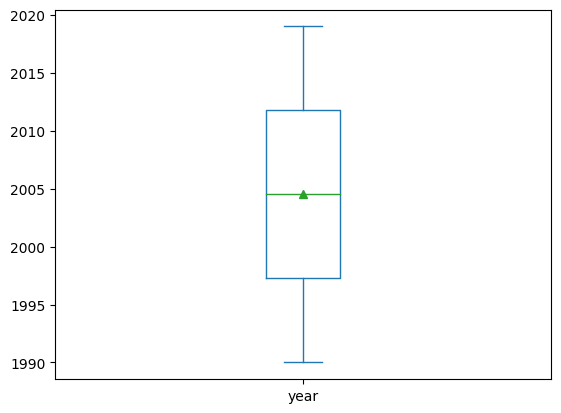

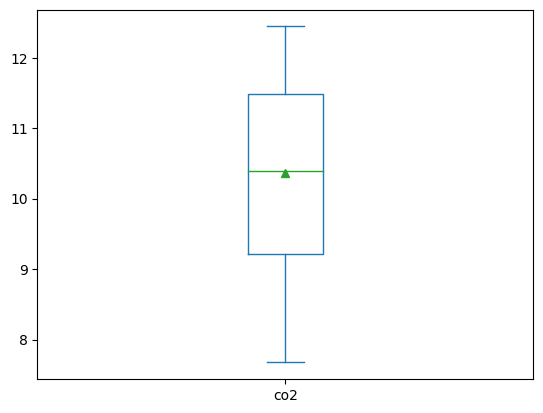

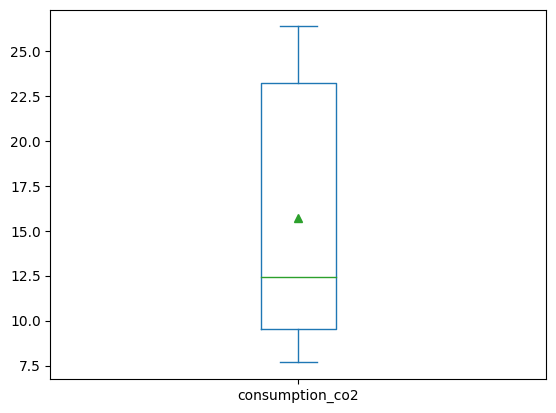

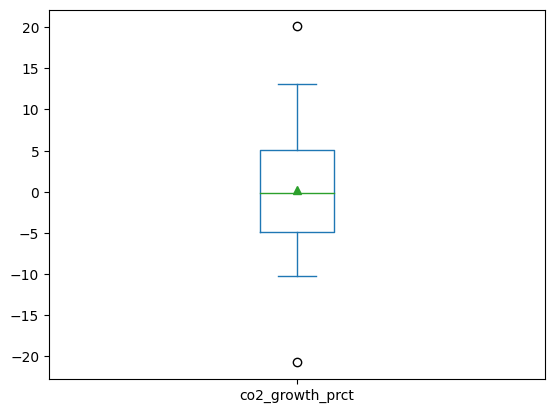

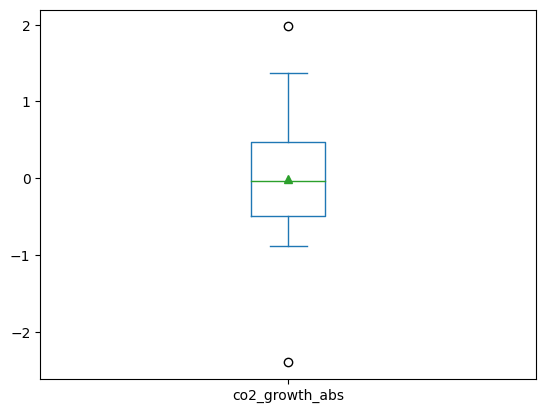

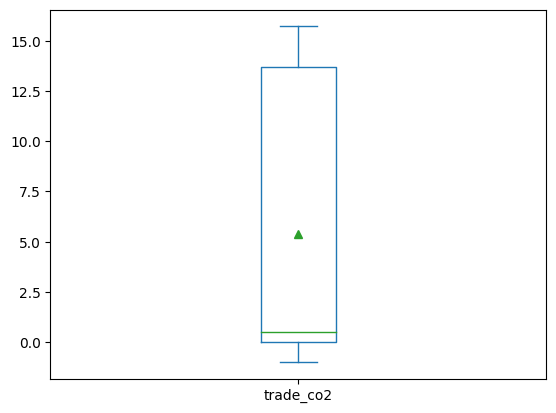

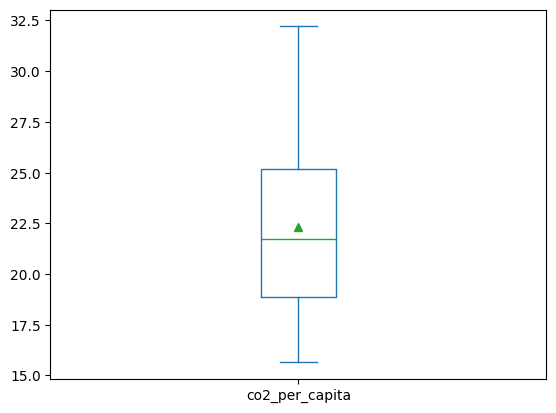

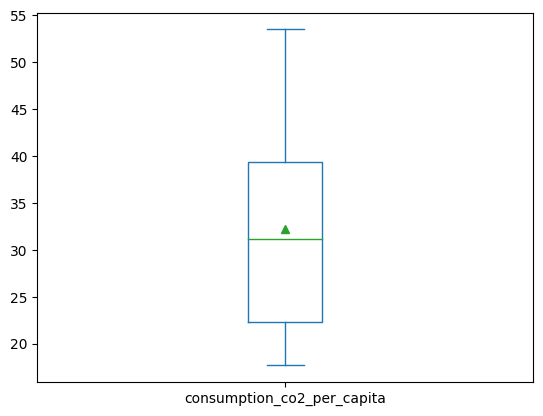

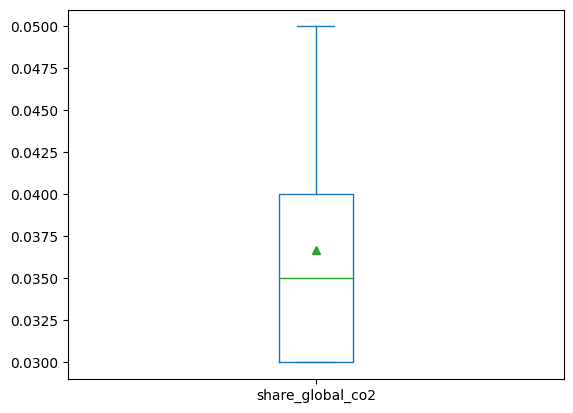

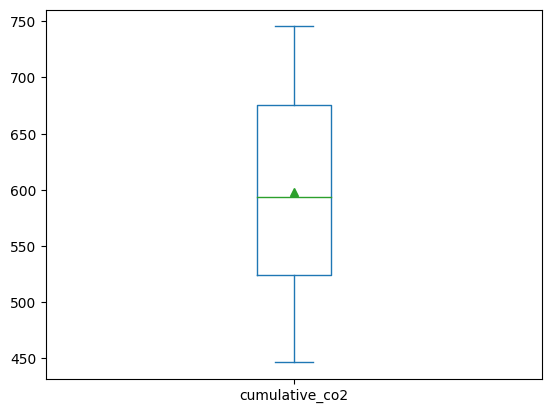

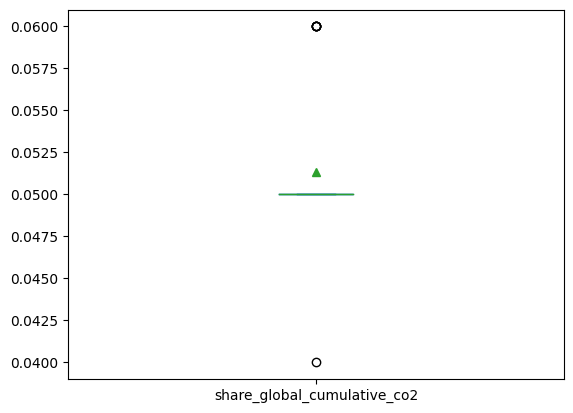

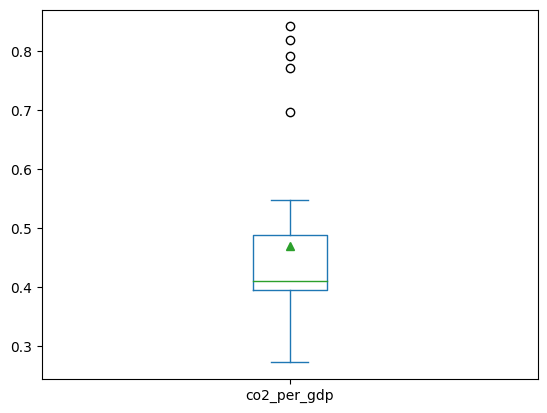

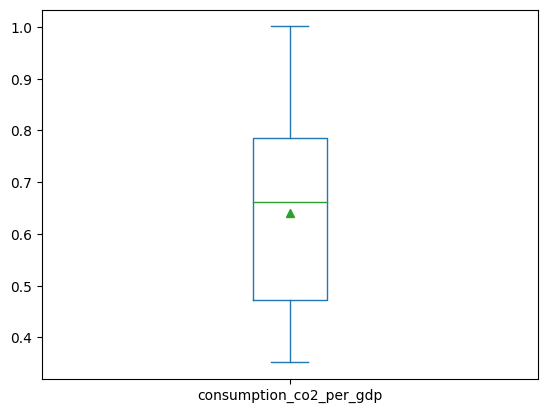

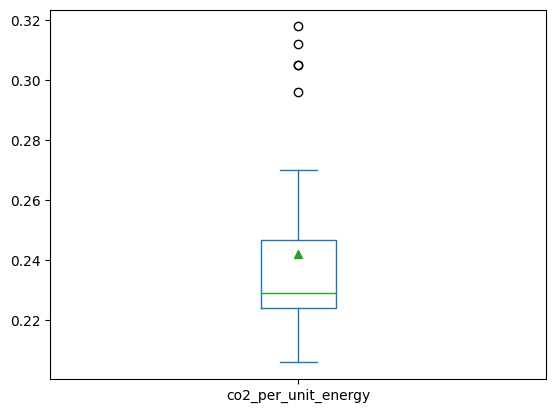

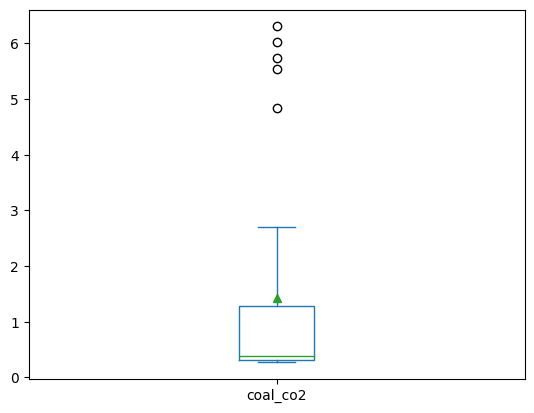

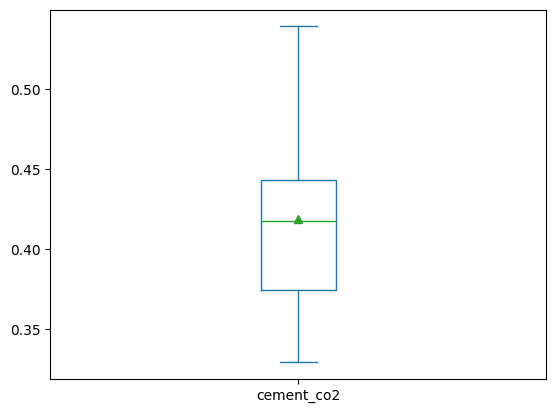

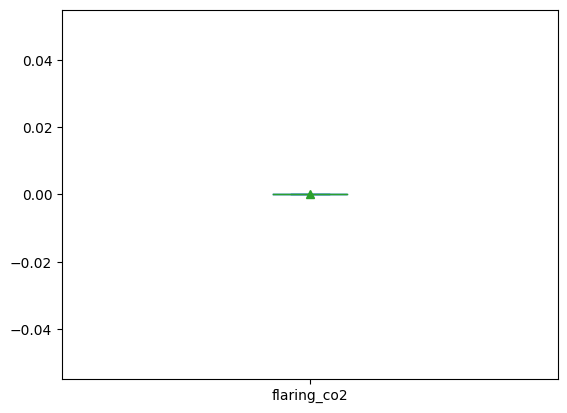

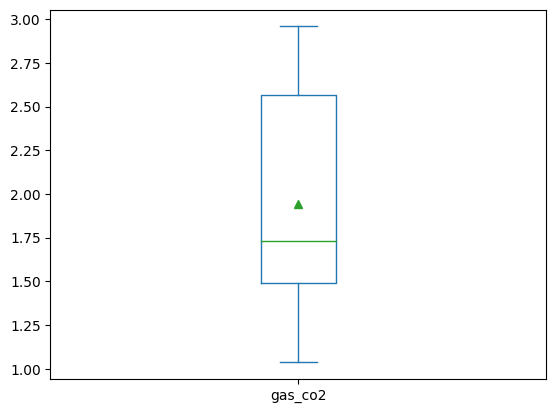

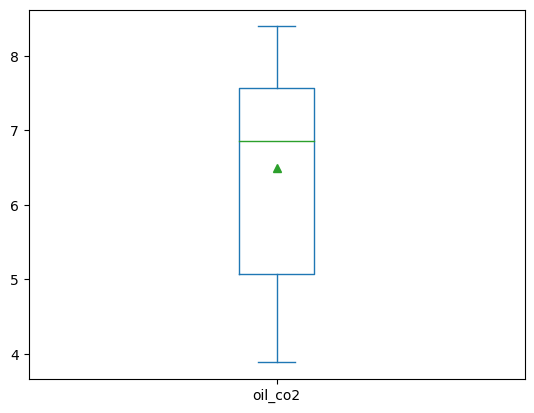

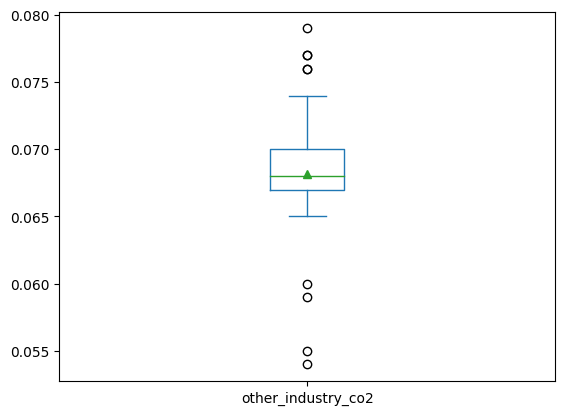

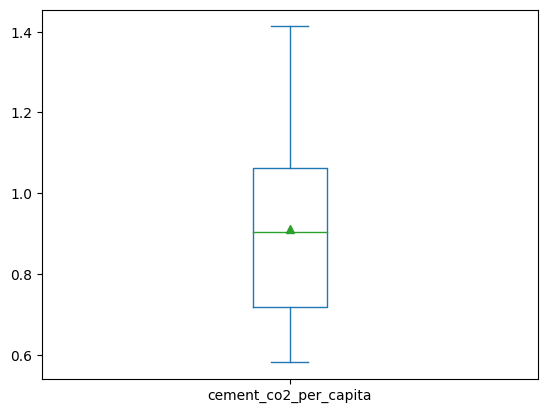

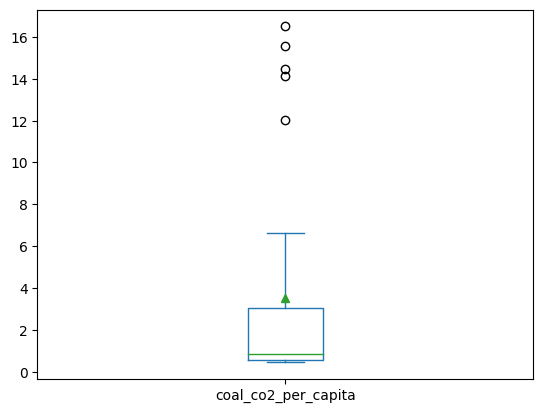

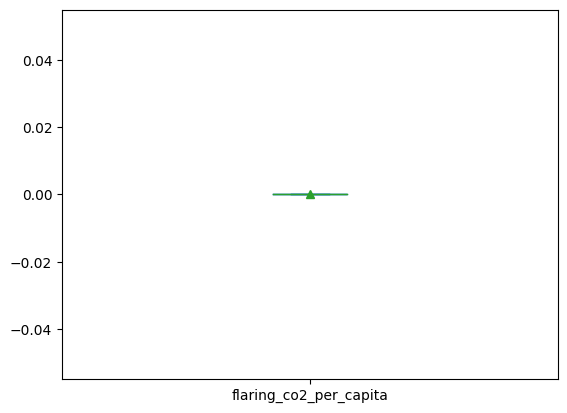

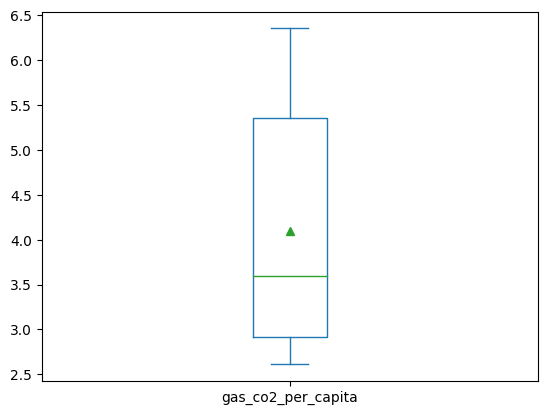

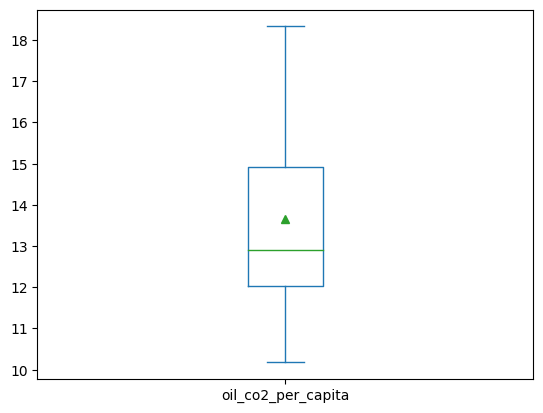

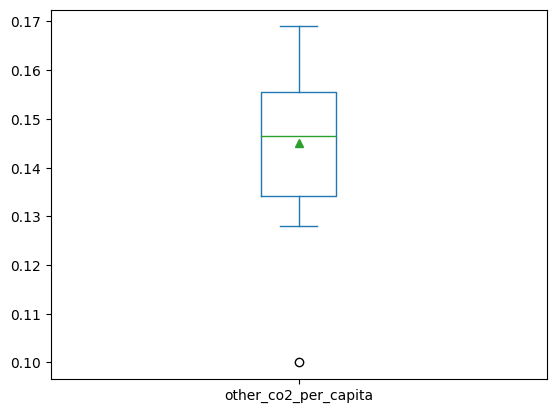

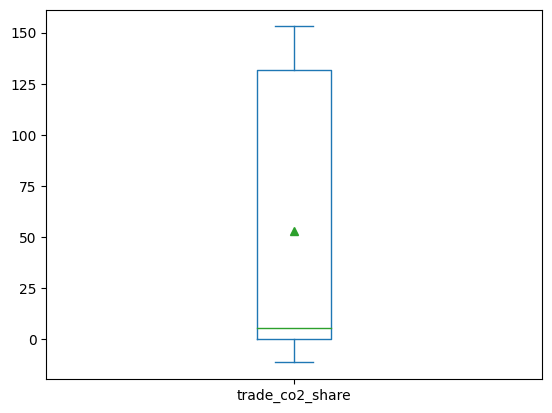

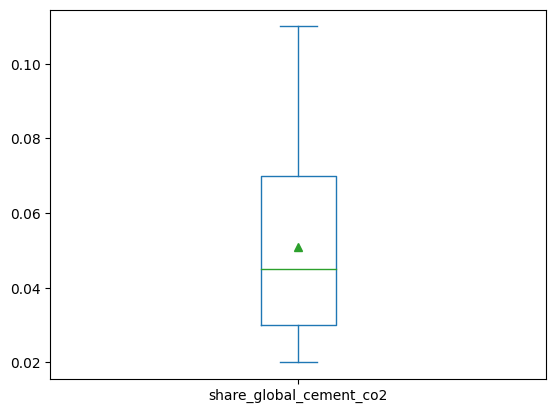

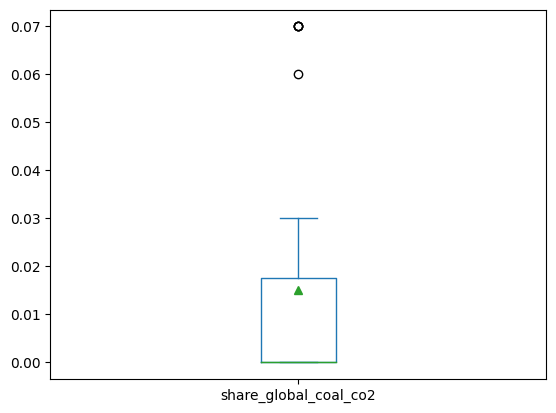

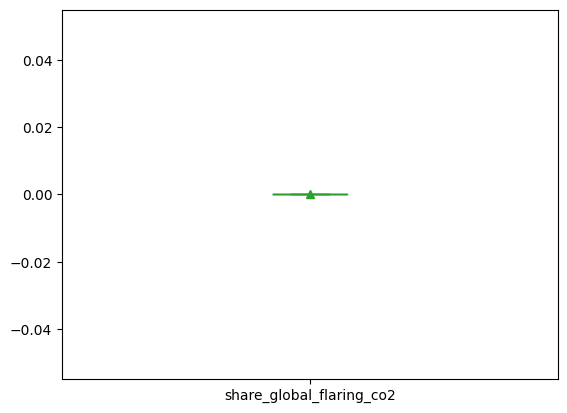

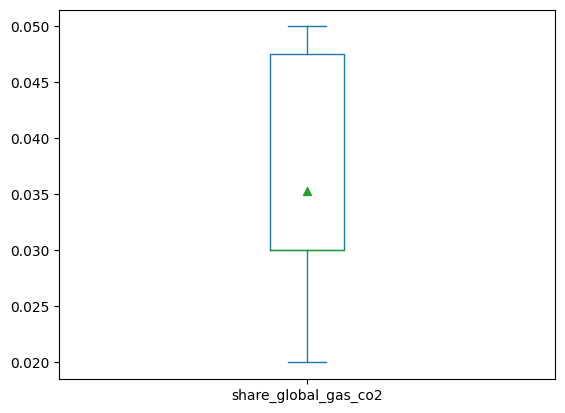

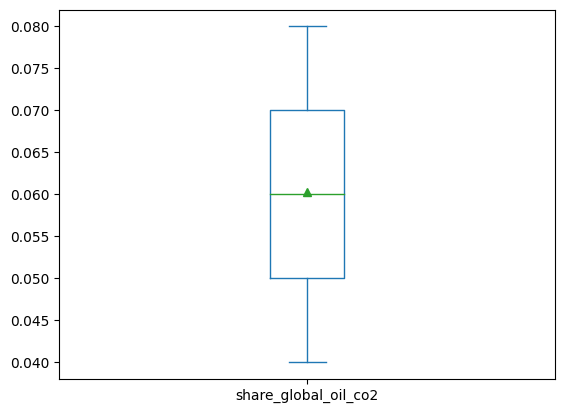

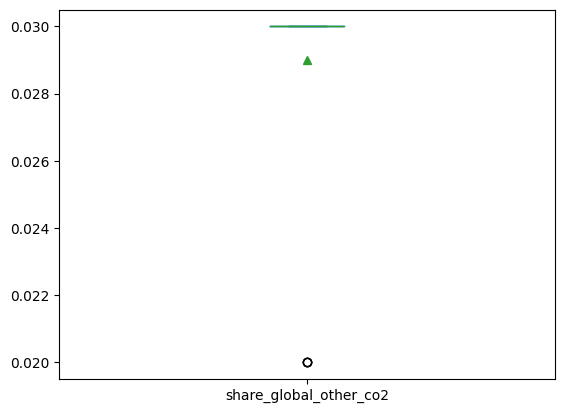

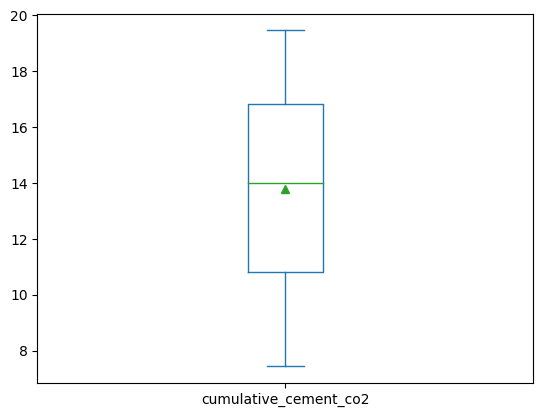

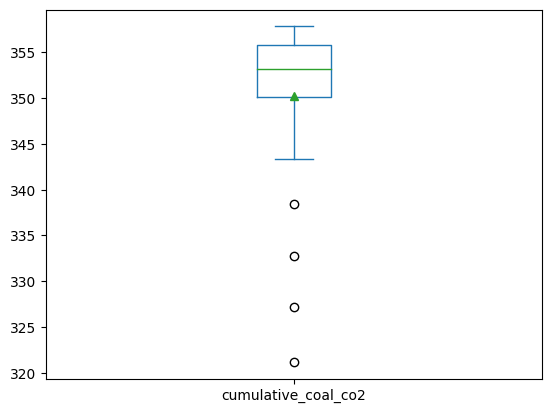

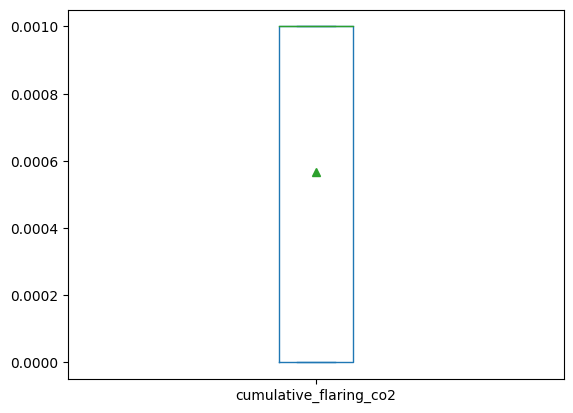

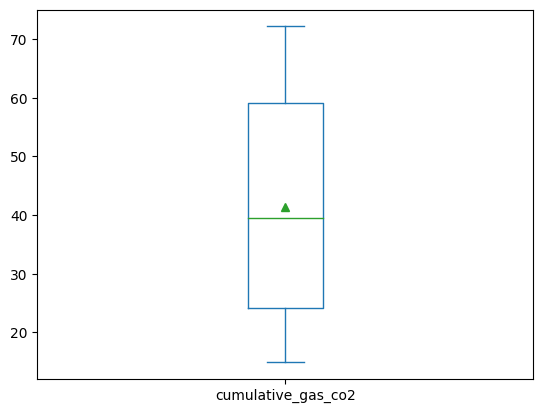

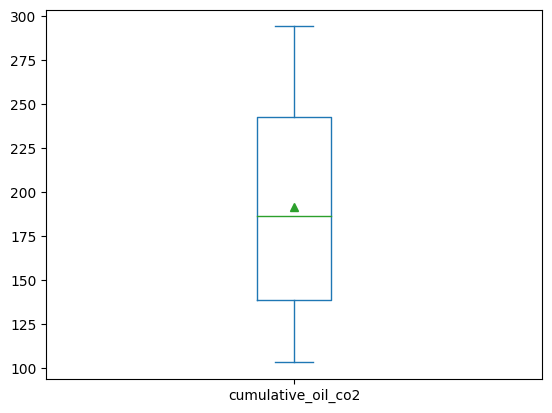

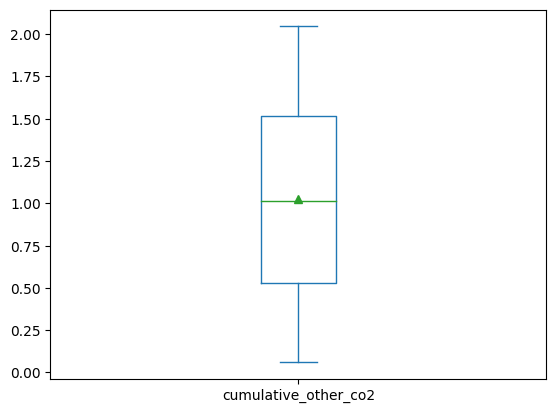

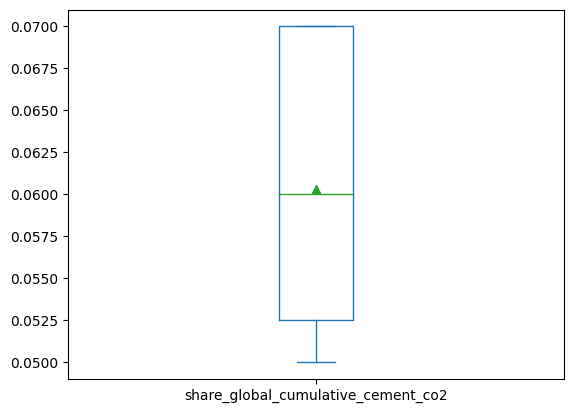

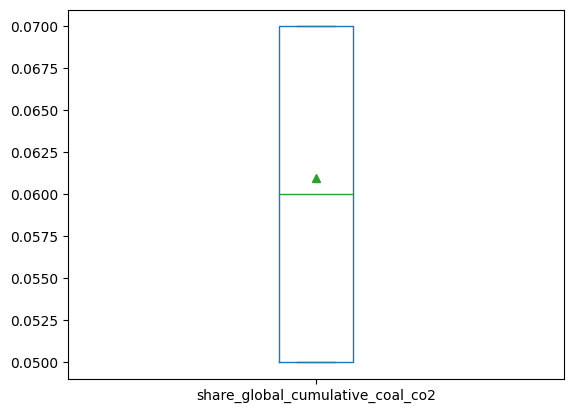

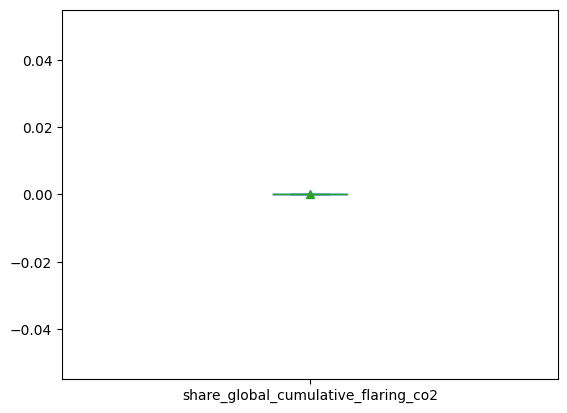

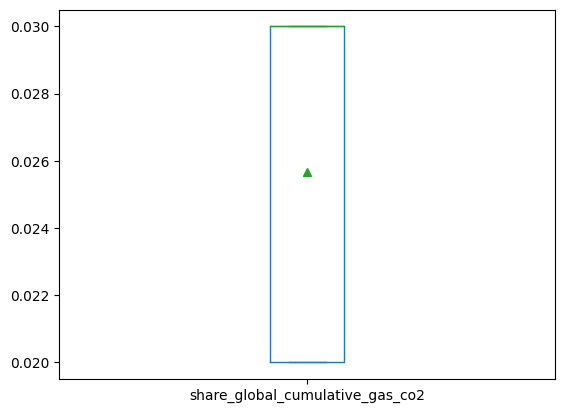

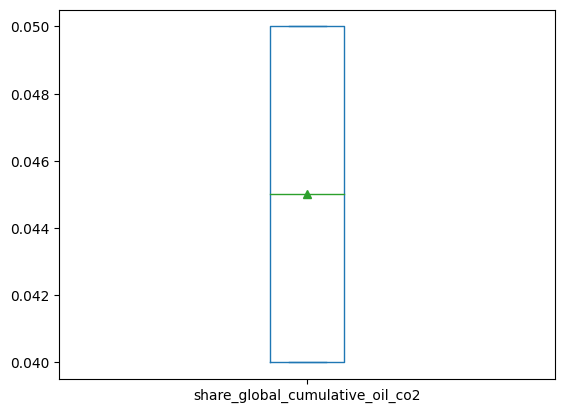

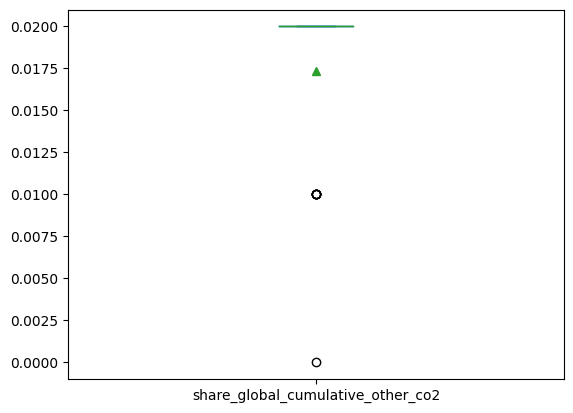

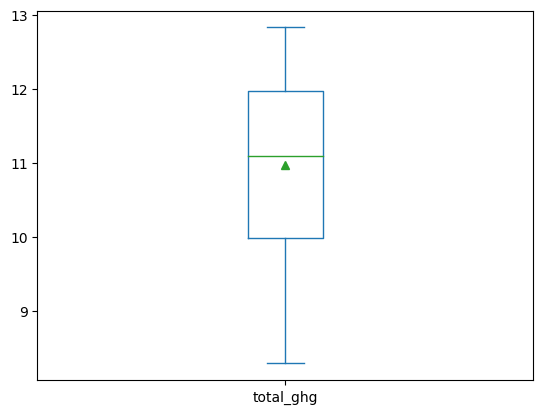

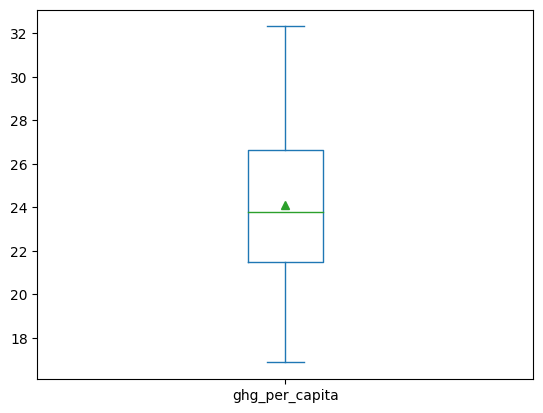

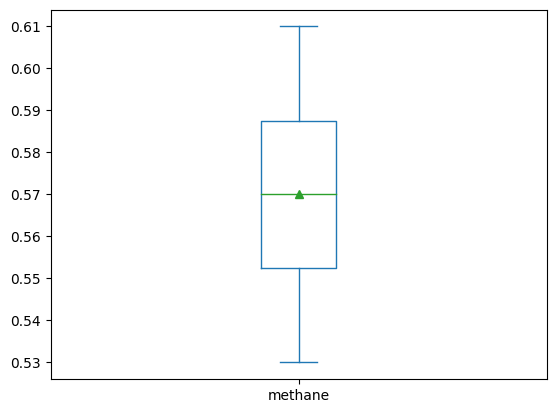

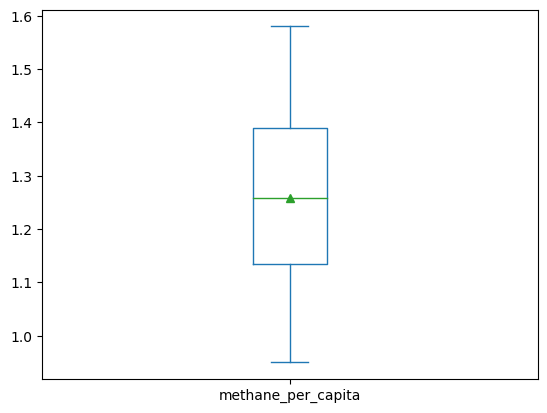

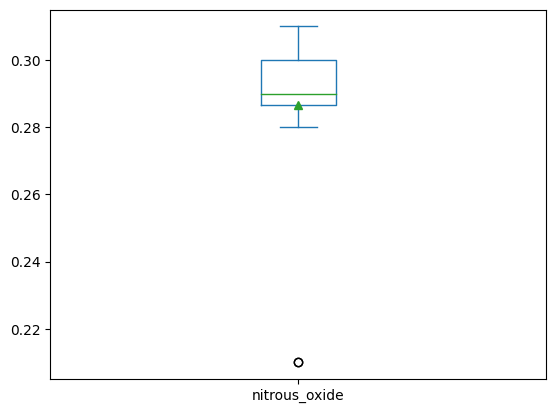

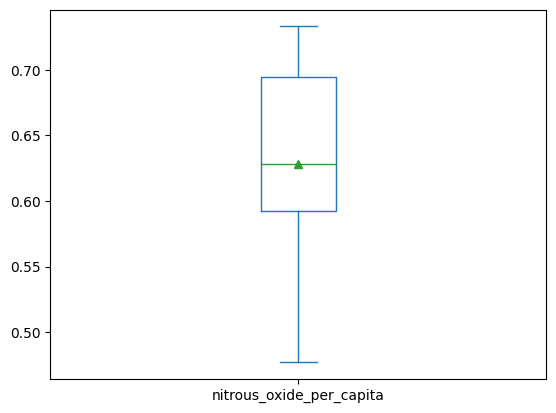

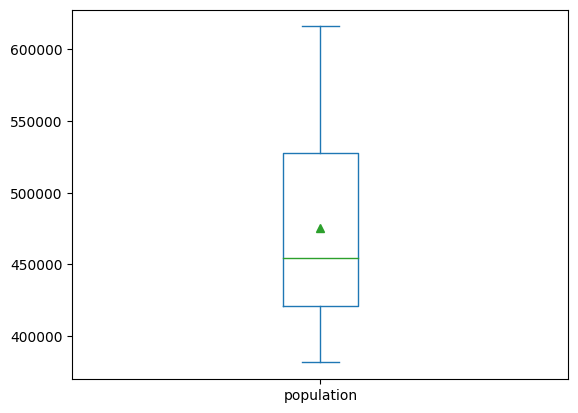

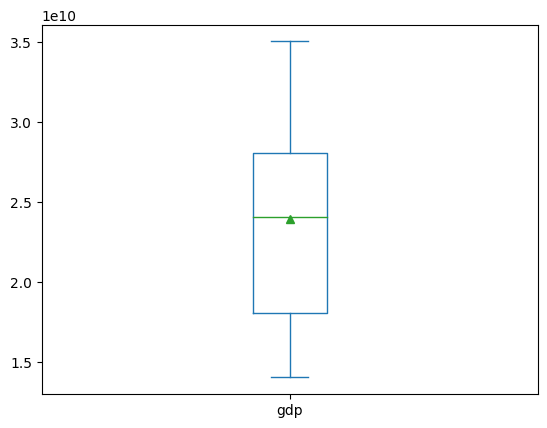

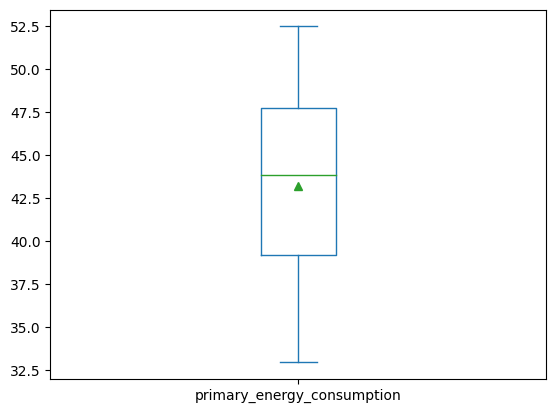

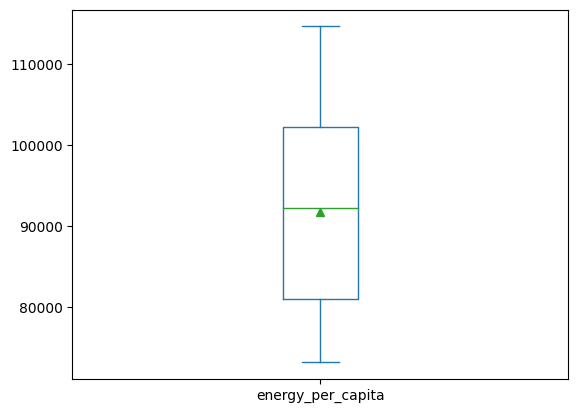

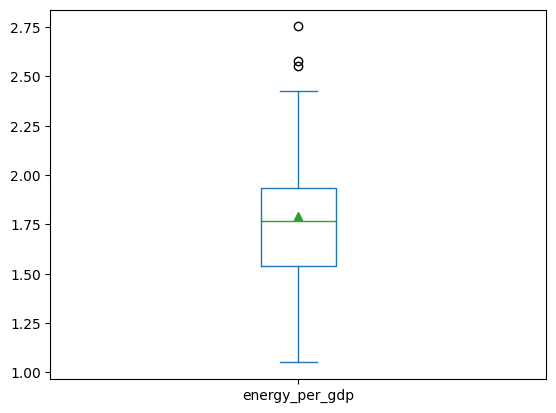

In [263]:
def boxplot_pint(df_input):
    for column in df_input:
        df_input[column].plot(kind='box', vert=True, showmeans=True)
        plt.xticks(rotation=0, ha='center')
        plt.show()

boxplot_pint(df_Lux)

Histograms and bell curve shape of each variable distribution

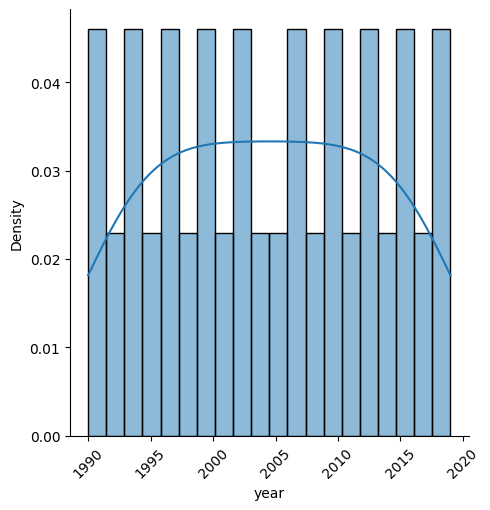

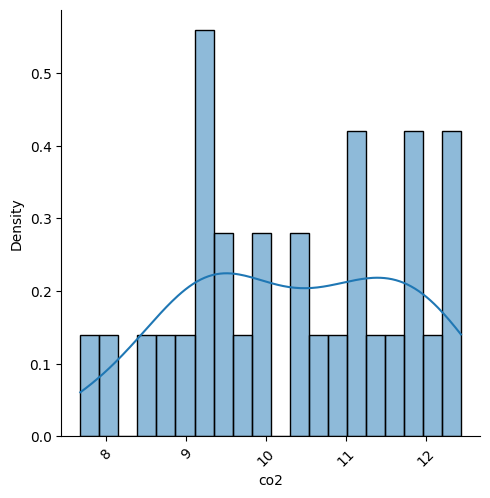

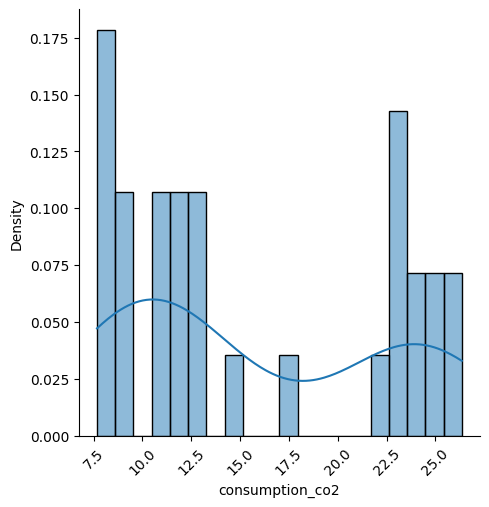

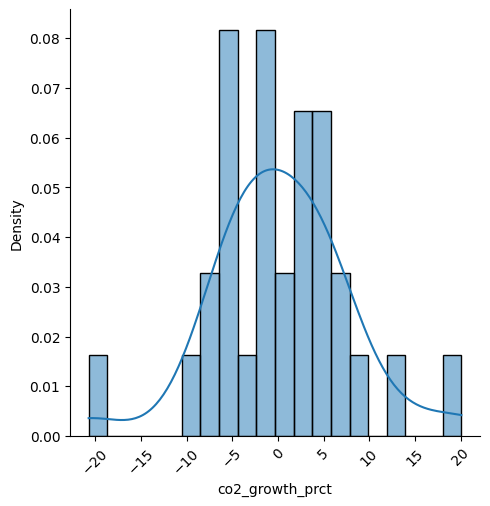

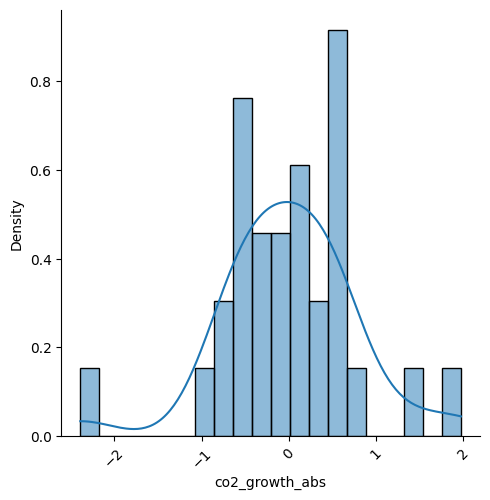

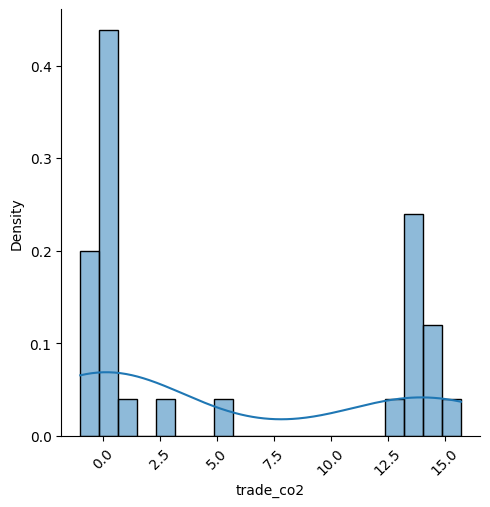

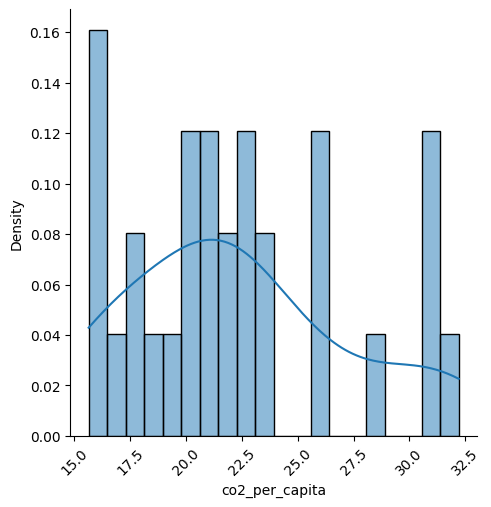

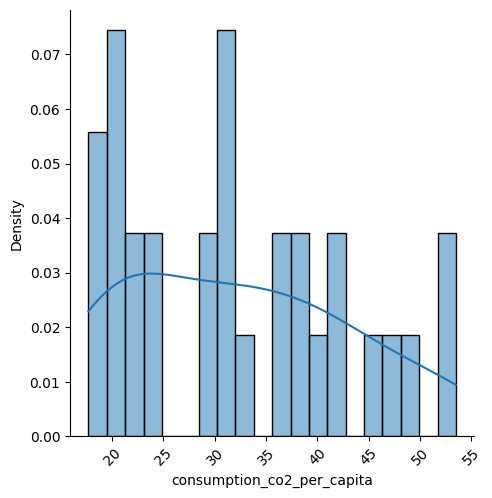

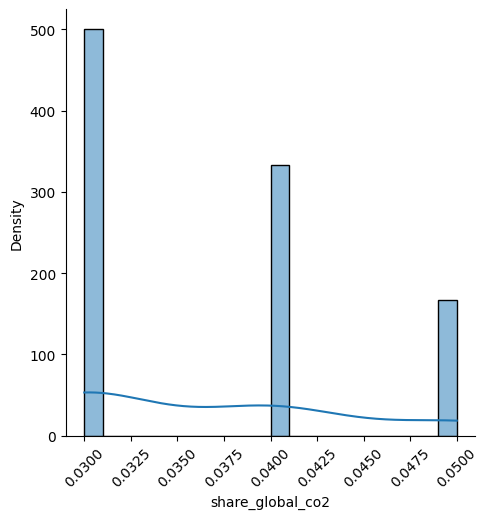

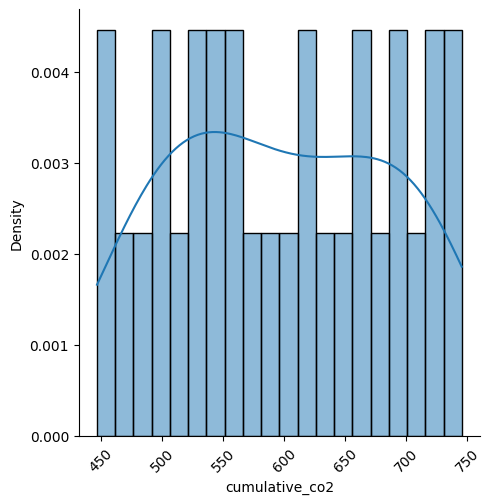

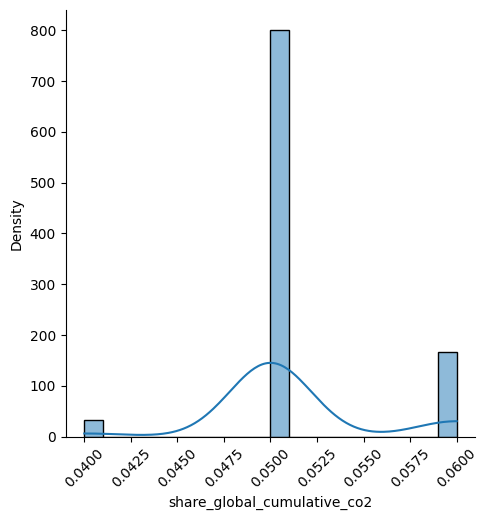

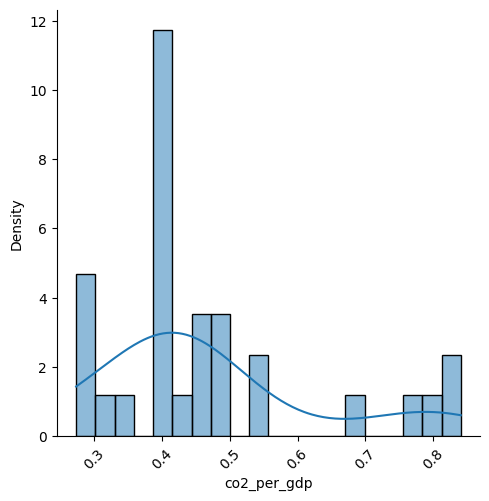

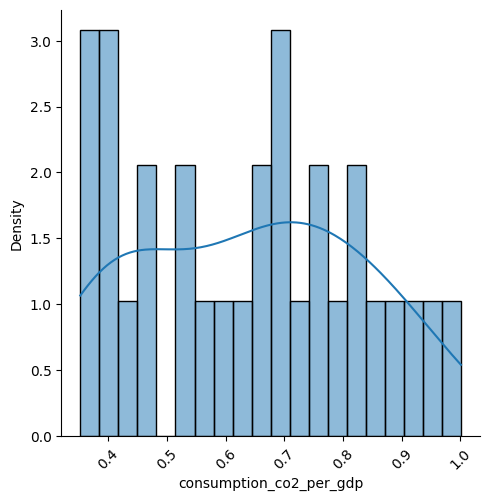

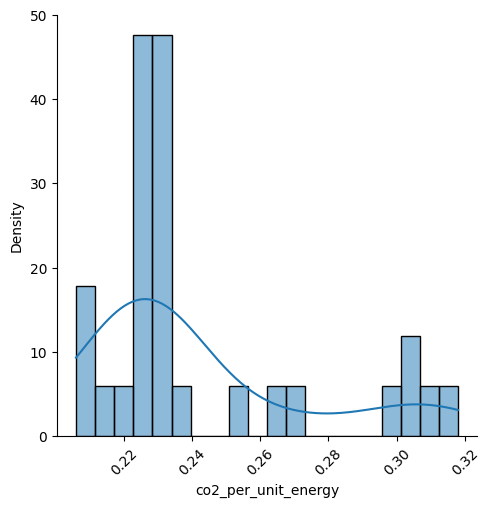

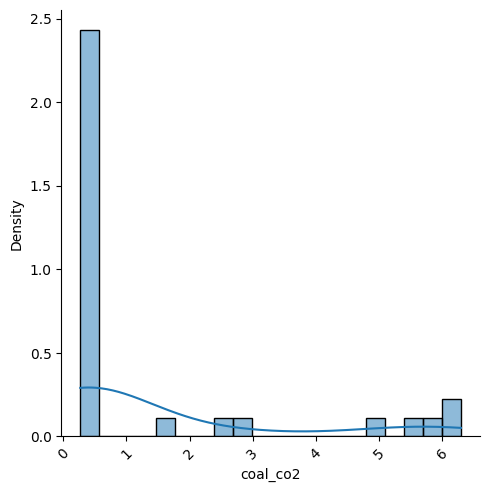

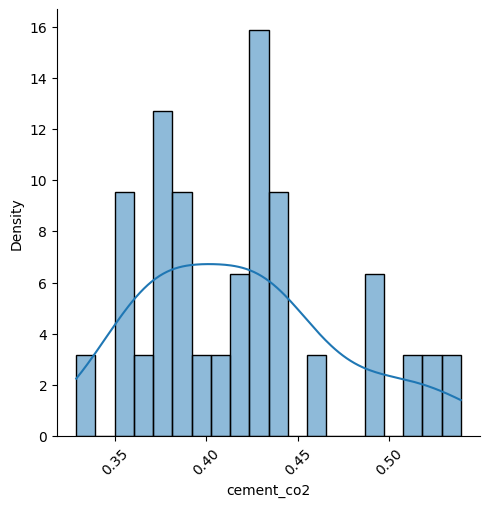

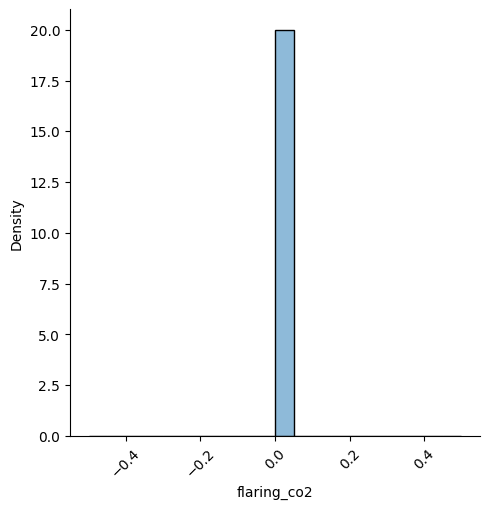

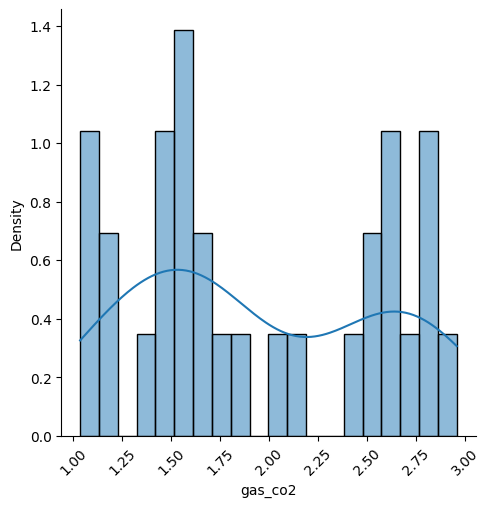

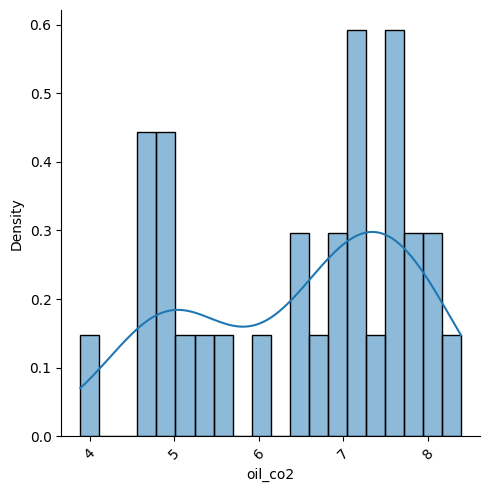

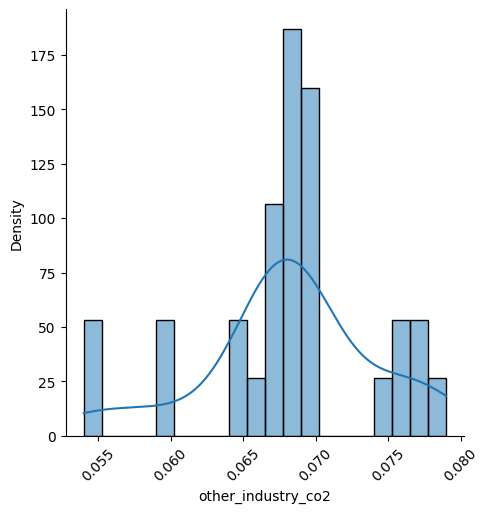

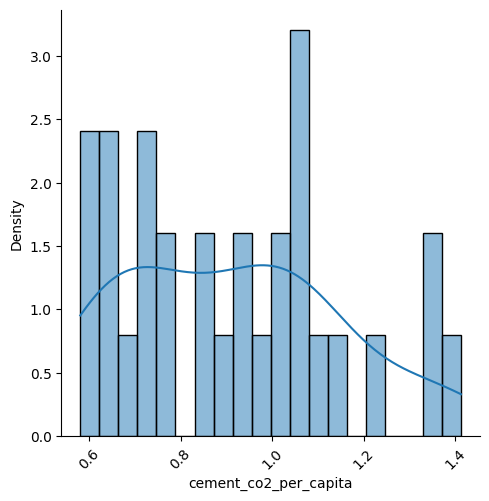

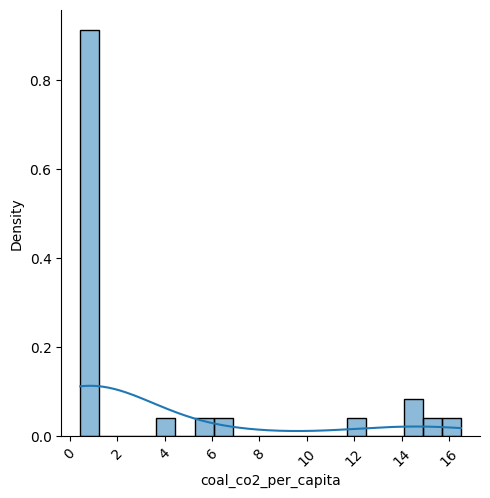

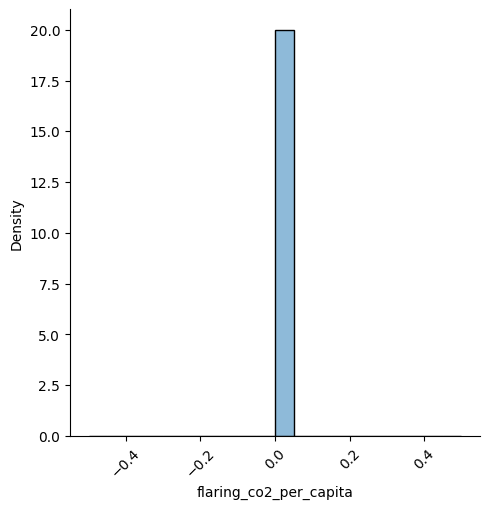

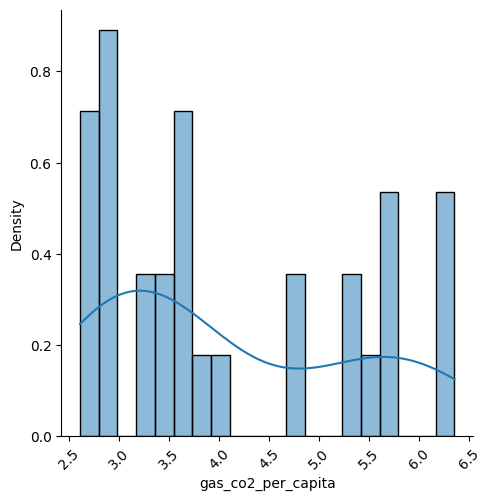

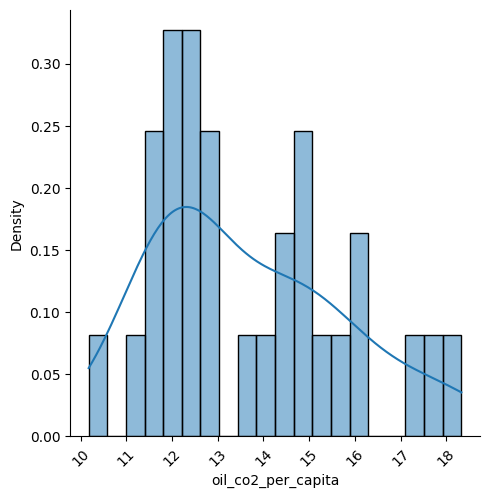

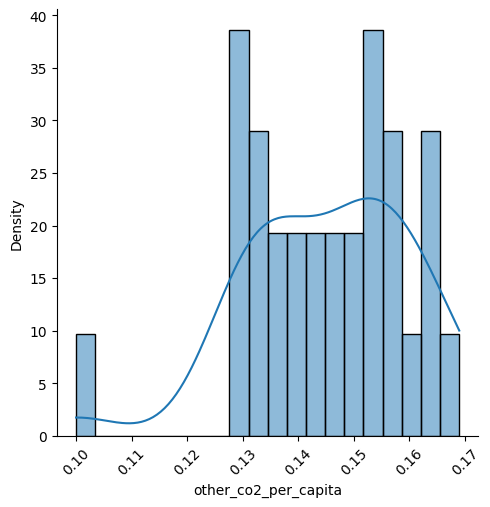

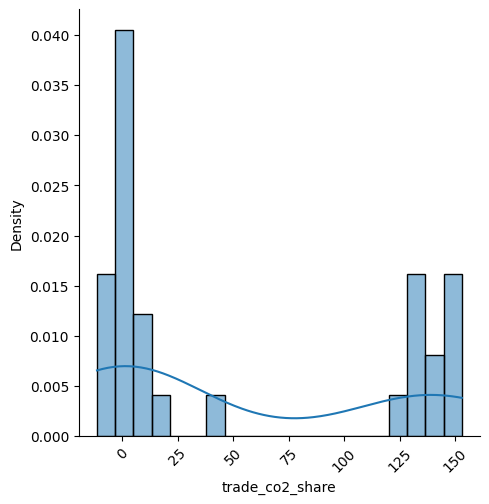

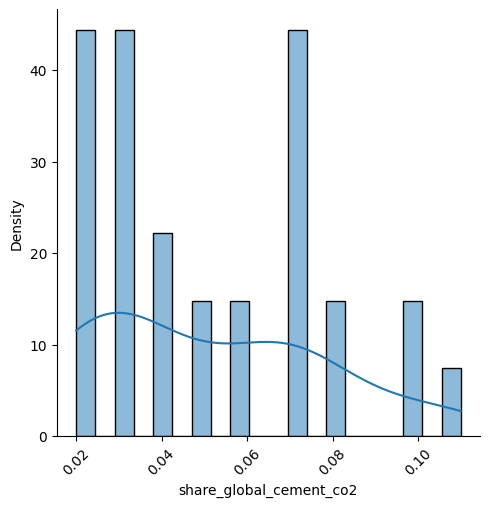

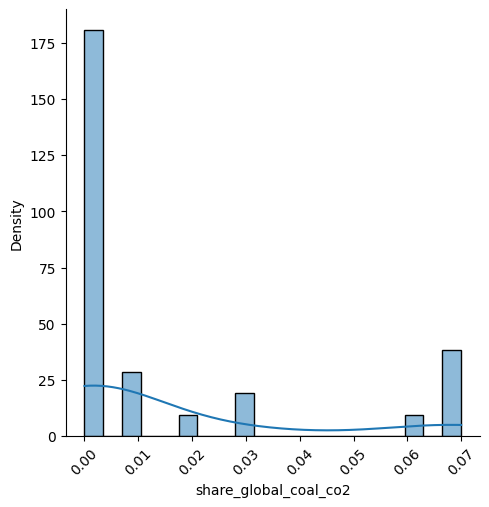

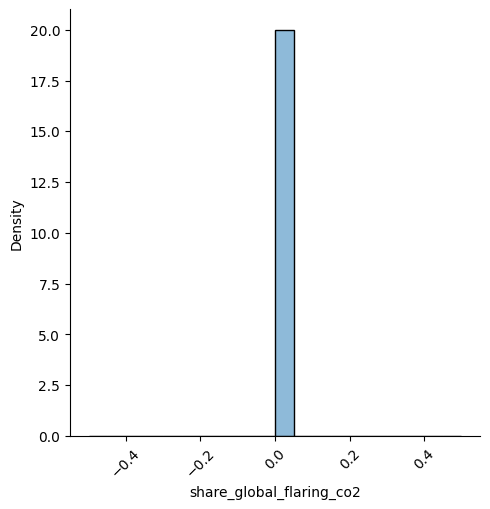

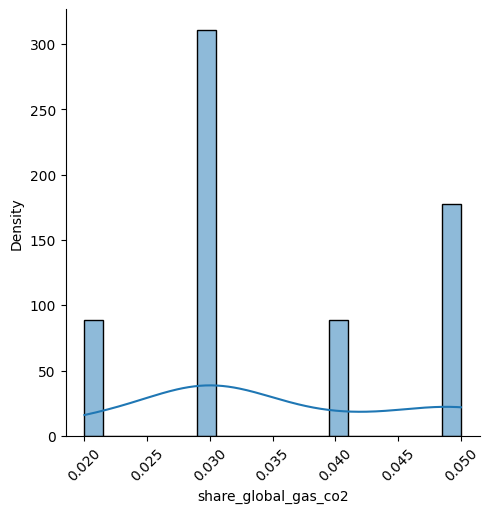

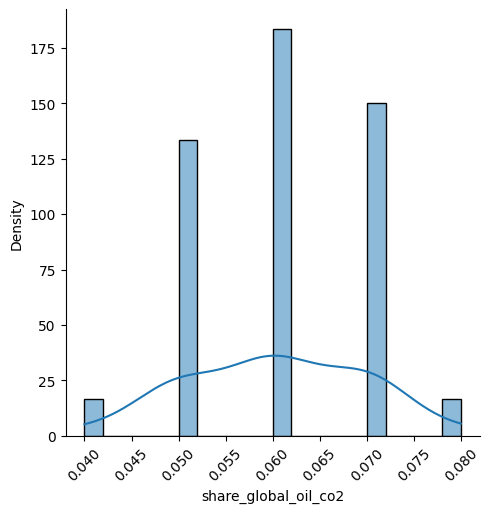

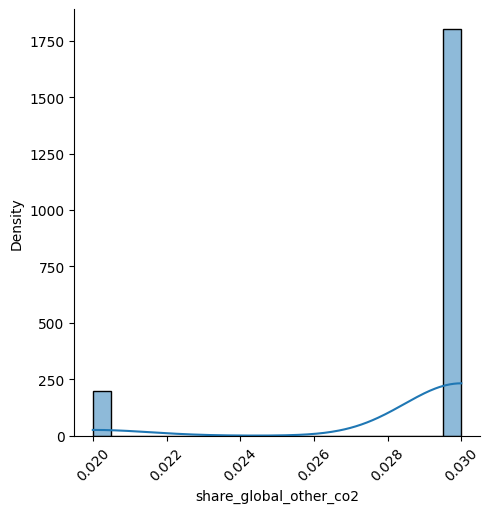

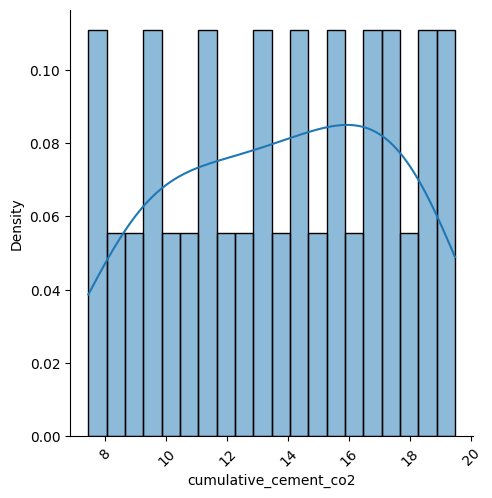

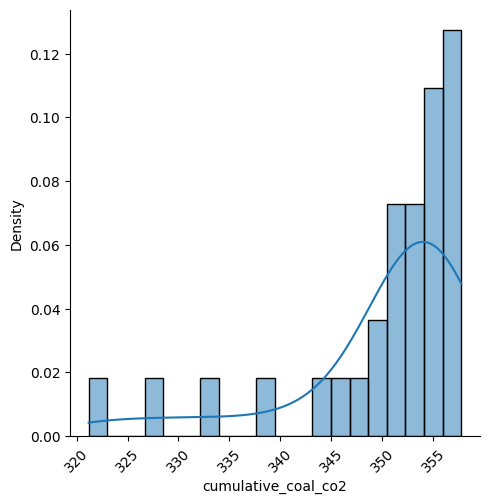

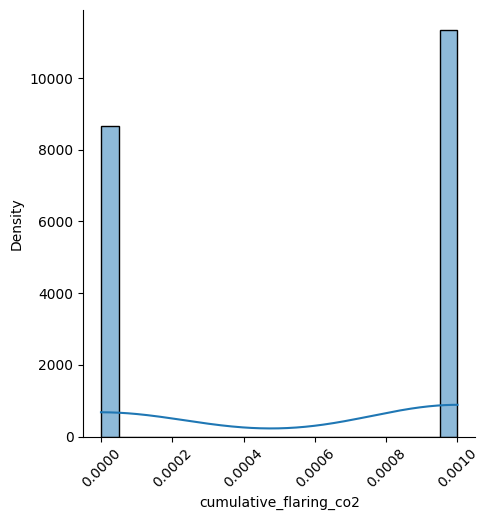

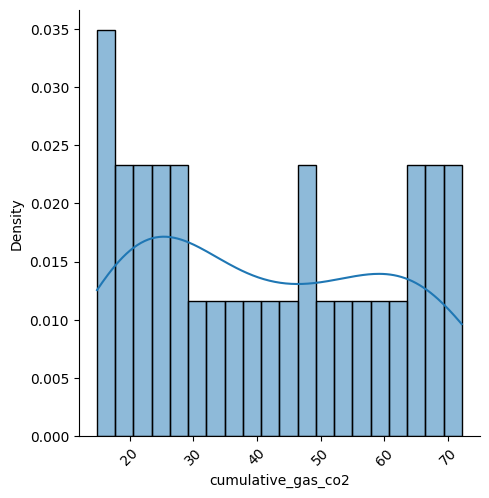

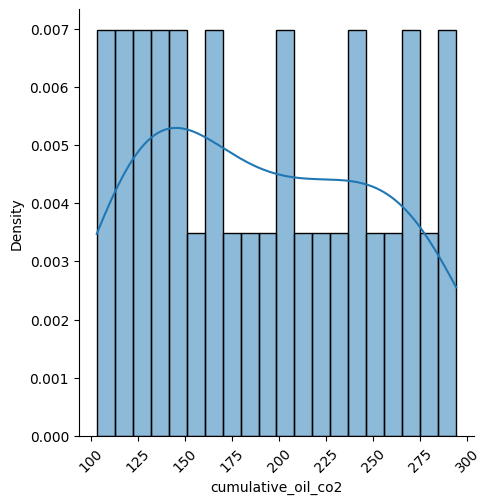

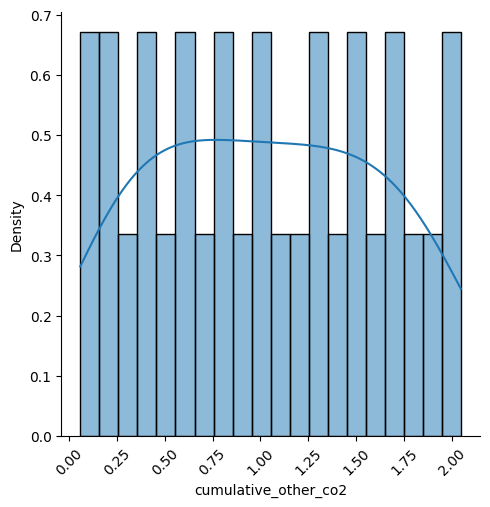

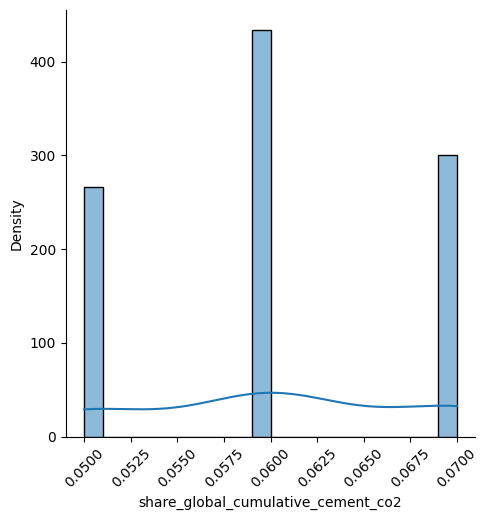

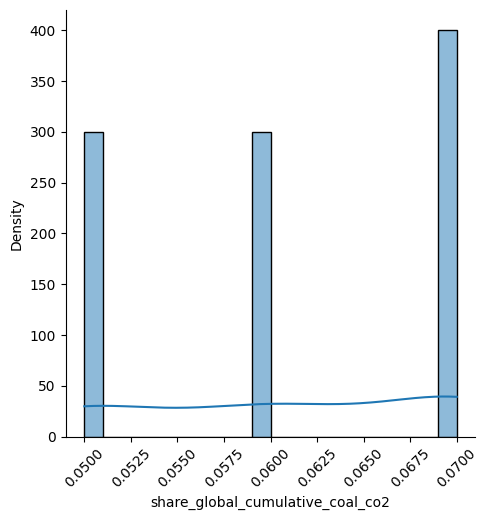

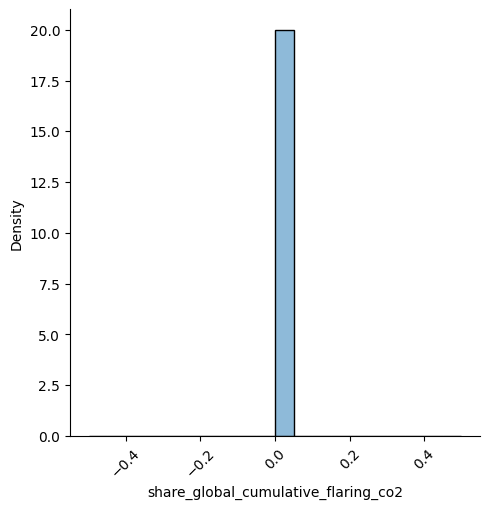

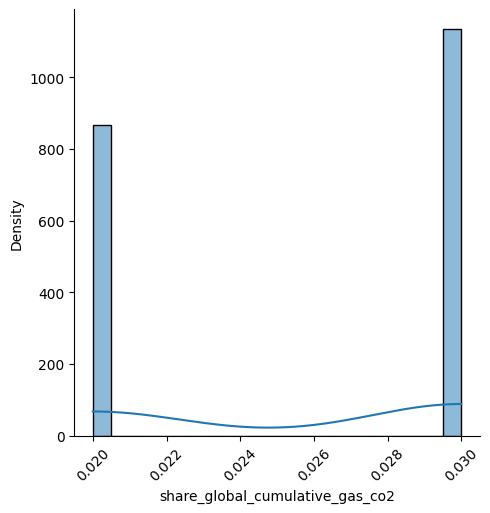

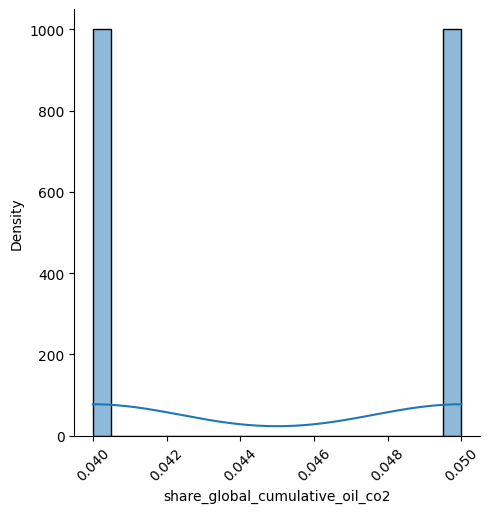

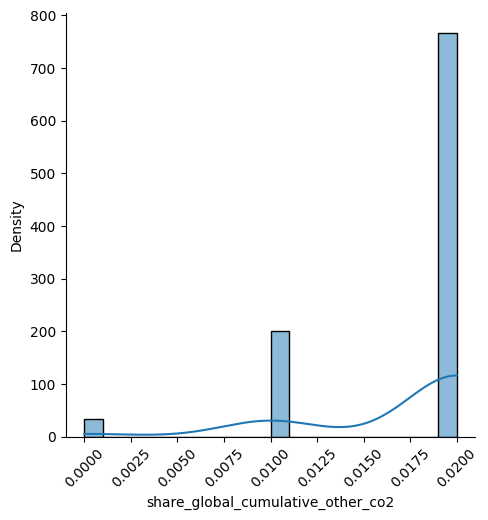

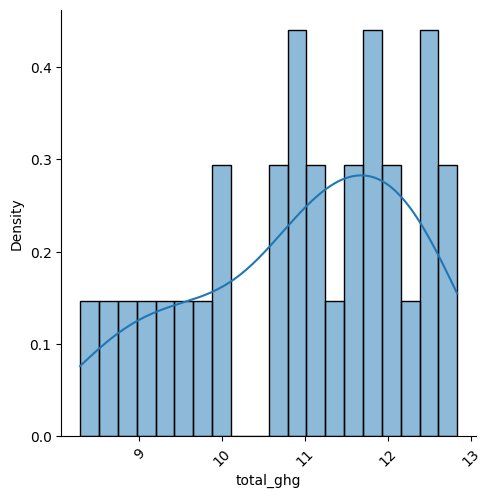

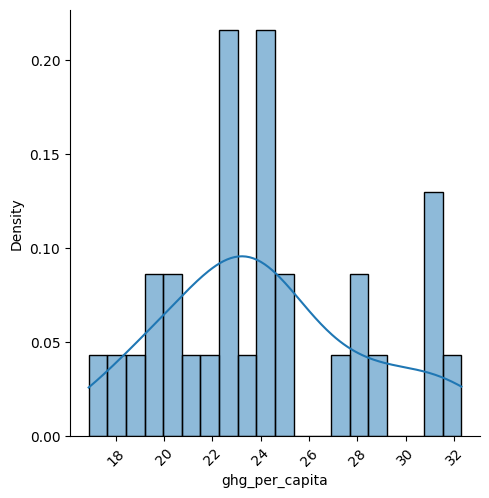

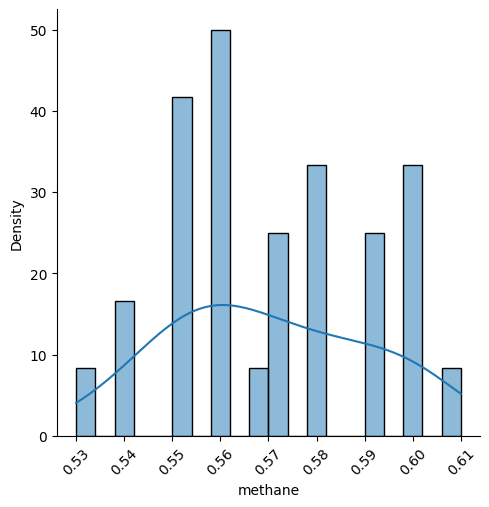

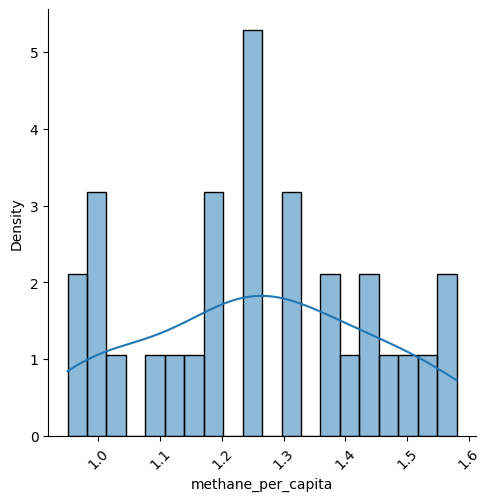

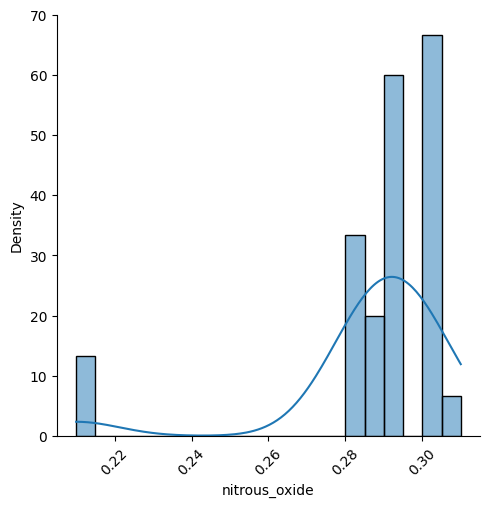

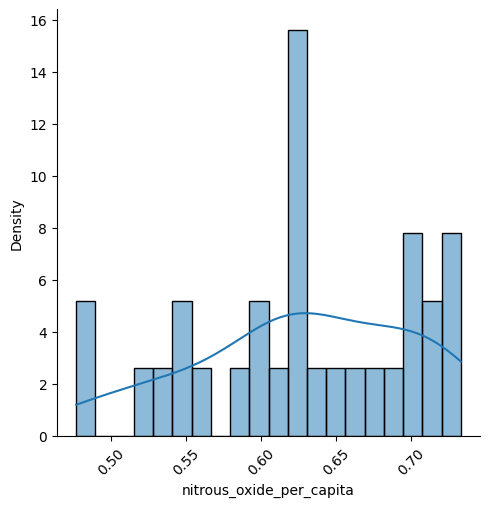

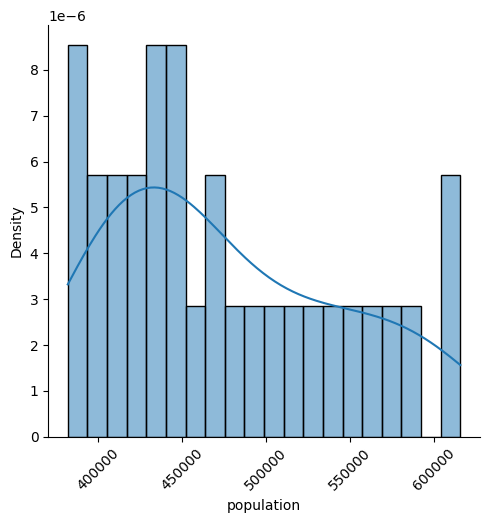

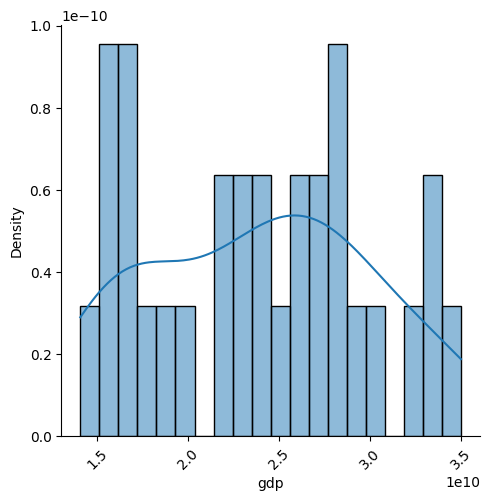

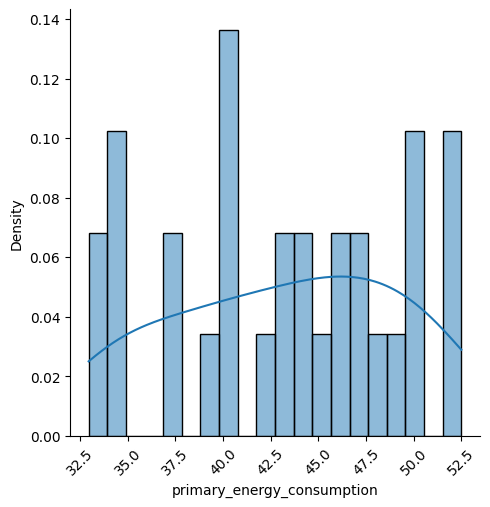

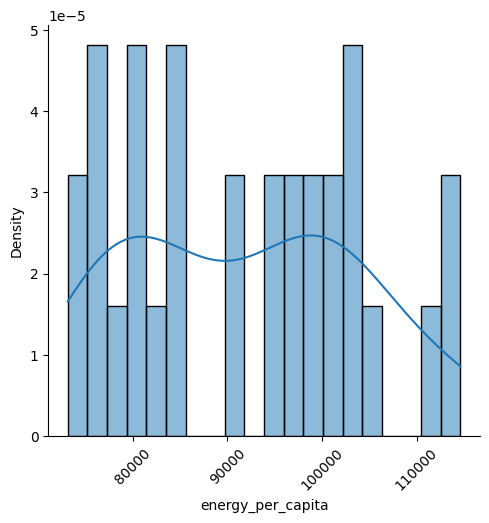

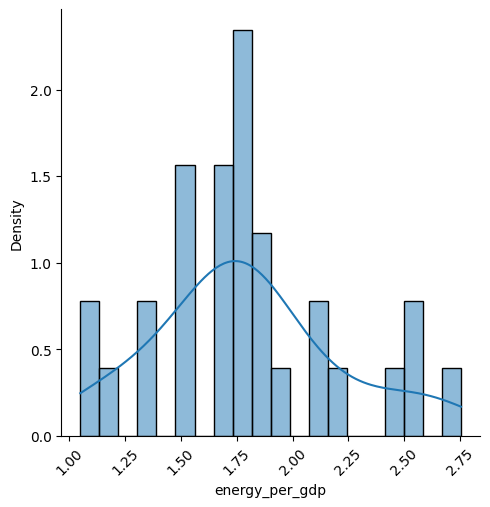

In [264]:
def histogram_pint(df_input):
    for column in df_input:
        df_input[column].replace('', np.nan)
        df_input[column].dropna(how="all", inplace=True)
        sns.displot(data=df_input, x=column, kind='hist', bins=20, stat='density', kde=True)
        plt.xlabel(column)
        plt.xticks(rotation=45)
        plt.show()
        #plt.semilogx()

histogram_pint(df_Lux)

Discriptive statistics

In [265]:
df.describe()

year           co2  consumption_co2  co2_growth_prct  \
count  25204.000000  23949.000000      3976.000000     24931.000000   
mean    1953.225797    267.861942       916.755170        21.098600   
std       53.791369   1521.680894      3373.348275       702.565991   
min     1750.000000      0.000000         0.197000       -99.640000   
25%     1925.000000      0.528000        10.319750        -0.450000   
50%     1967.000000      4.857000        57.091000         3.350000   
75%     1995.000000     42.818000       276.378750        10.460000   
max     2020.000000  36702.503000     36702.503000    102318.510000   

       co2_growth_abs    trade_co2  co2_per_capita  \
count    23585.000000  3976.000000    23307.000000   
mean         5.146889    -2.415624        4.170811   
std         55.259760   182.444942       14.912201   
min      -1895.244000 -1657.998000        0.000000   
25%         -0.011000    -0.892500        0.253000   
50%          0.059000     1.953000        1.250000   
75%          1.103000     9.700500        4.657500   
max       1736.258000  1028.487000      748.639000   

       consumption_co2_per_capita  share_global_co2  cumulative_co2  \
count          3976.000000             23949.000000    2.394900e+04   
mean              6.567721                 4.983979    1.035710e+04   
std               6.927957                17.704994    6.120603e+04   
min               0.055000                 0.000000    0.000000e+00   
25%               1.240250                 0.010000    6.992000e+00   
50%               4.359500                 0.060000    9.131800e+01   
75%               9.848500                 0.600000    1.147514e+03   
max              57.792000               100.000000    1.696524e+06   

       share_global_cumulative_co2   co2_per_gdp  consumption_co2_per_gdp  \
count         23949.000000          15389.000000          3761.000000       
mean              5.126531              0.421795             0.370038       
std              18.480079              0.483864             0.265374       
min               0.000000              0.000000             0.006000       
25%               0.000000              0.140000             0.216000       
50%               0.030000              0.276000             0.315000       
75%               0.410000              0.534000             0.447000       
max             100.000000              7.776000             3.543000       

       co2_per_unit_energy      coal_co2    cement_co2  flaring_co2  \
count          9141.000000  17188.000000  12248.000000  4382.000000   
mean              0.238931    175.358171     12.888607    15.000326   
std               0.233550    786.106838     77.258563    40.471977   
min               0.005000      0.000000      0.000000     0.000000   
25%               0.178000      0.322000      0.129000     0.253250   
50%               0.218000      3.981000      0.557000     2.071500   
75%               0.256000     35.532750      2.896750    12.603750   
max               4.644000  15062.902000   1626.371000   435.034000   

           gas_co2       oil_co2  other_industry_co2  cement_co2_per_capita  \
count  8845.000000  20539.000000         1999.000000         12218.000000     
mean    108.750774    106.254381           15.753891             0.113037     
std     441.064563    602.683622           39.385589             0.148907     
min       0.000000      0.000000            0.000000             0.000000     
25%       0.385000      0.311000            0.747500             0.020000     
50%       4.199000      2.100000            2.861000             0.070000     
75%      30.830000     17.369000            9.902000             0.156000     
max    7553.394000  12229.642000          303.858000             2.738000     

       coal_co2_per_capita  flaring_co2_per_capita  gas_co2_per_capita  \
count         16860.000000          4381.000000            8835.000000   
mean              1.551520             0.875319       

In [266]:
CentralTendacy = {}

def central_tend(df_input):
    for column in df_input:
        CentralTendacy[str(column)+' Mean'] = df_input[column].mean()
        CentralTendacy[str(column)+' Median'] = df_input[column].median()
        CentralTendacy[str(column)+' Mode'] = df_input[column].mode()[0]

central_tend(df_Lux)
CentralTendacy

{'year Mean': 2004.5,
 'year Median': 2004.5,
 'year Mode': 1990,
 'co2 Mean': 10.359133333333336,
 'co2 Median': 10.39,
 'co2 Mode': 7.676,
 'consumption_co2 Mean': 15.719233333333333,
 'consumption_co2 Median': 12.399000000000001,
 'consumption_co2 Mode': 7.676,
 'co2_growth_prct Mean': 0.24333333333333323,
 'co2_growth_prct Median': -0.19499999999999995,
 'co2_growth_prct Mode': -20.71,
 'co2_growth_abs Mean': -0.0030999999999999804,
 'co2_growth_abs Median': -0.027499999999999997,
 'co2_growth_abs Mode': -2.391,
 'trade_co2 Mean': 5.360033333333333,
 'trade_co2 Median': 0.495,
 'trade_co2 Mode': -0.0,
 'co2_per_capita Mean': 22.316800000000004,
 'co2_per_capita Median': 21.7455,
 'co2_per_capita Mode': 15.646,
 'consumption_co2_per_capita Mean': 32.1807,
 'consumption_co2_per_capita Median': 31.165,
 'consumption_co2_per_capita Mode': 17.685,
 'share_global_co2 Mean': 0.03666666666666667,
 'share_global_co2 Median': 0.035,
 'share_global_co2 Mode': 0.03,
 'cumulative_co2 Mean': 597

Q-Q and P-P plots

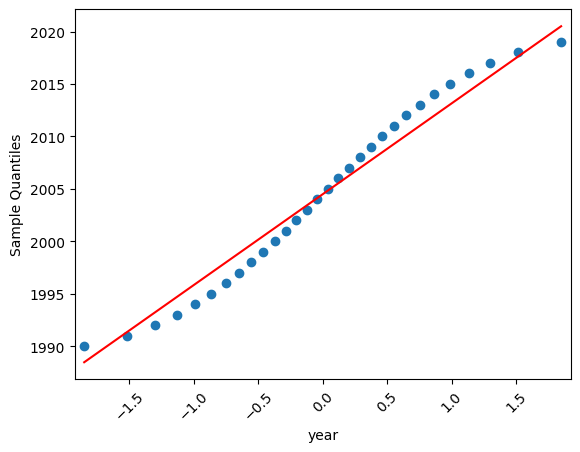

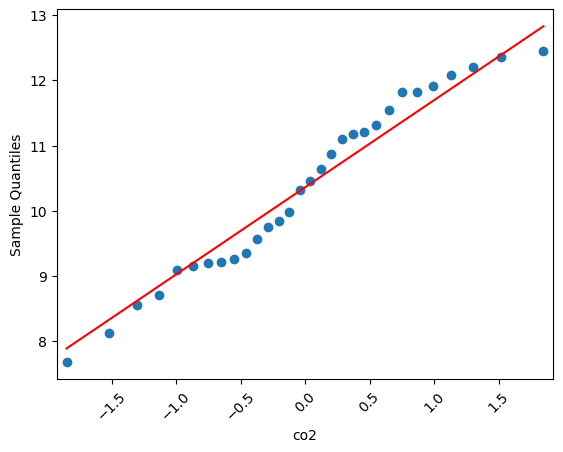

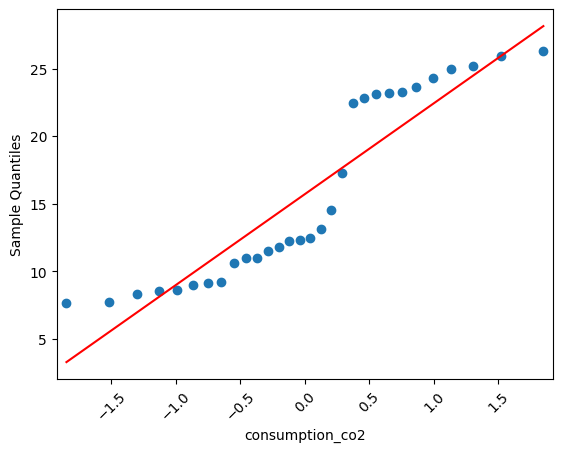

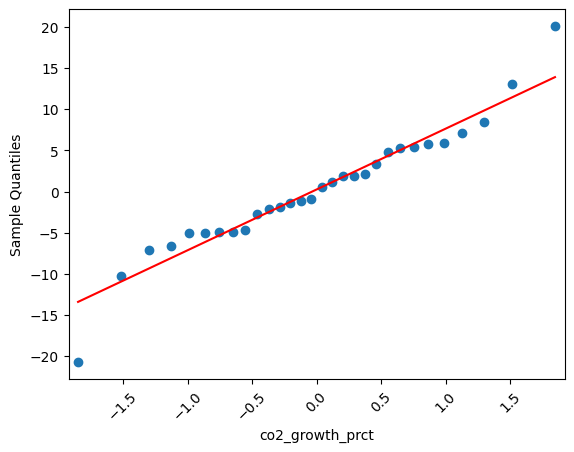

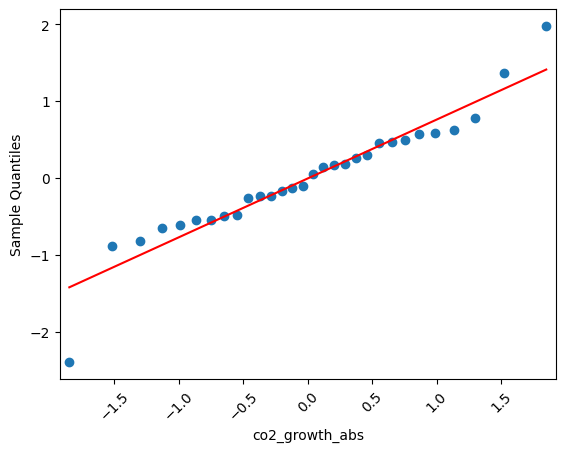

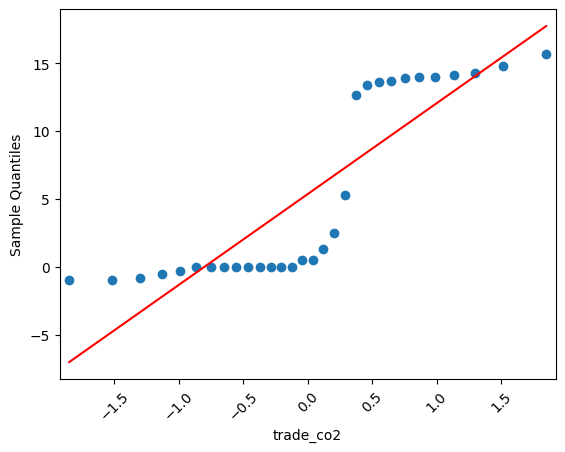

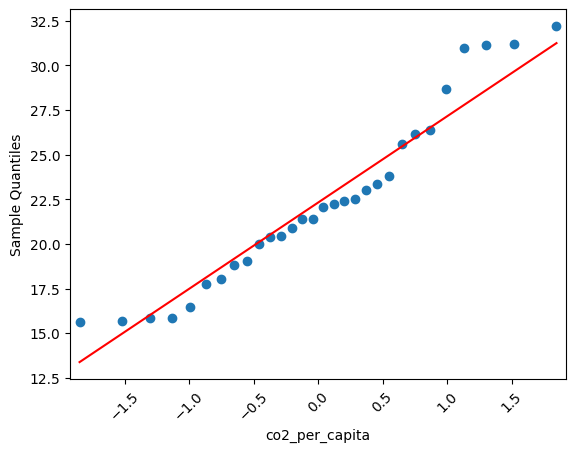

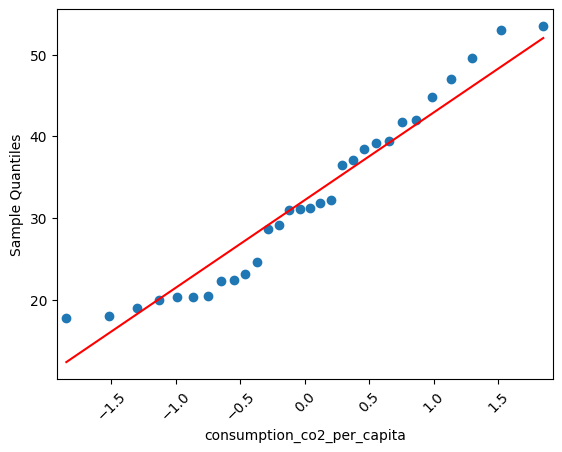

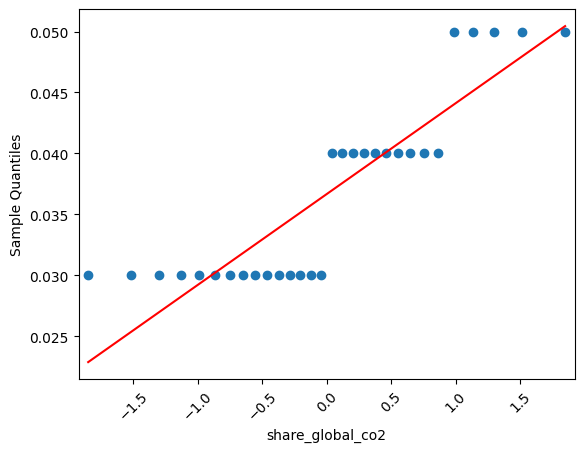

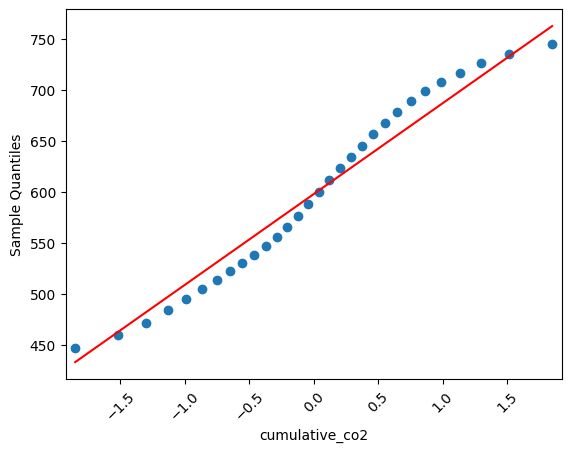

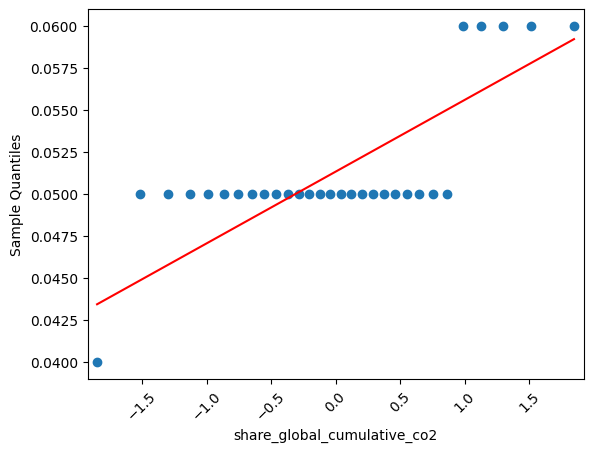

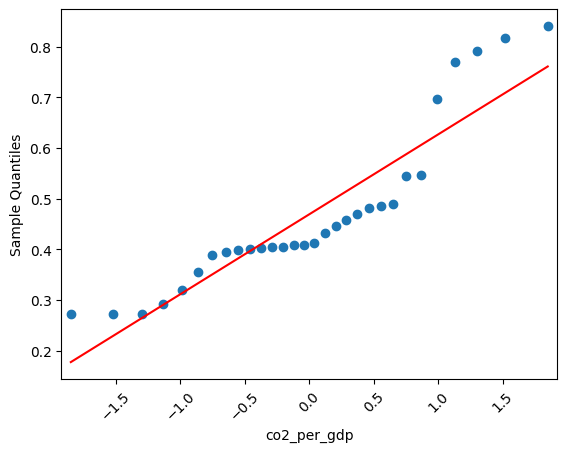

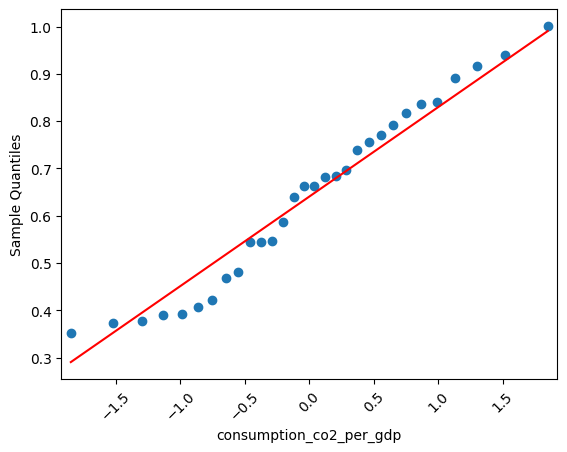

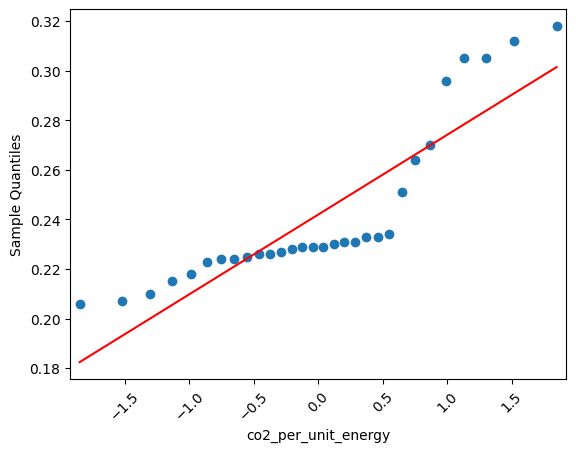

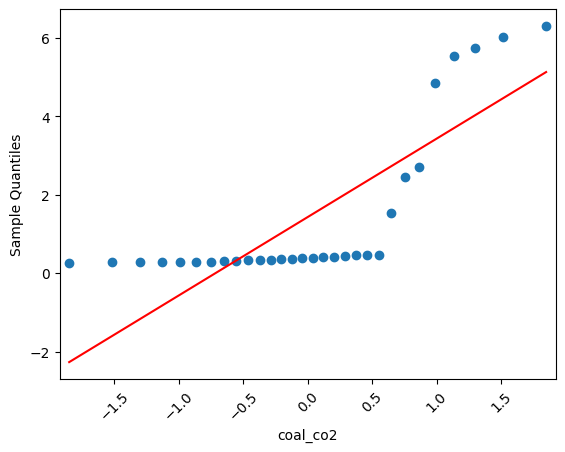

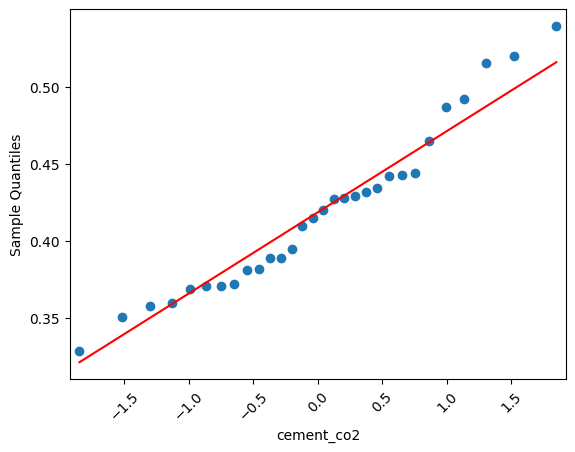

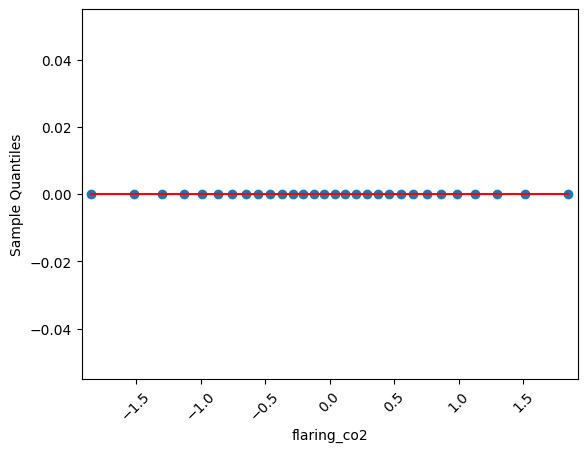

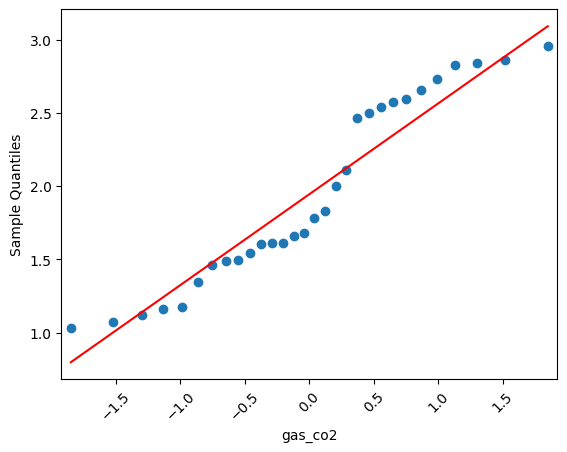

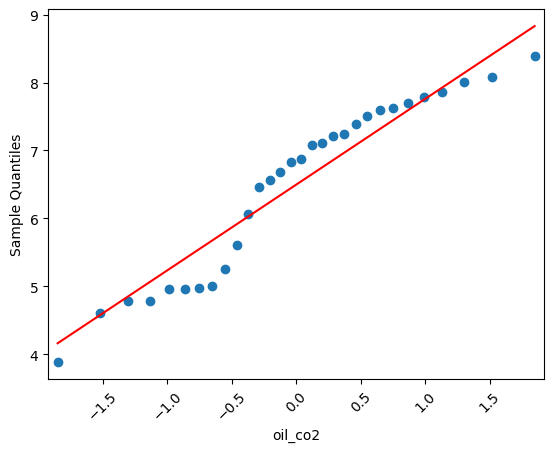

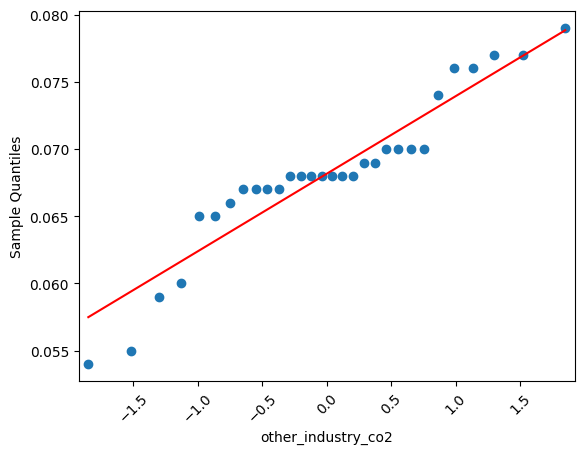

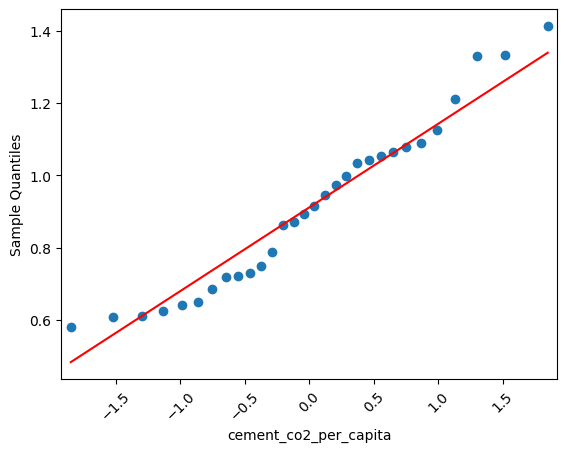

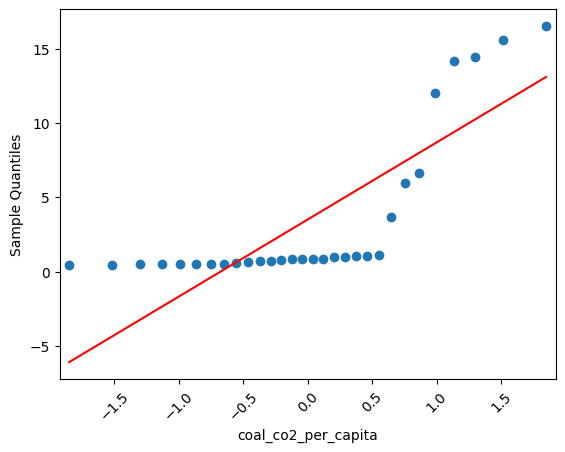

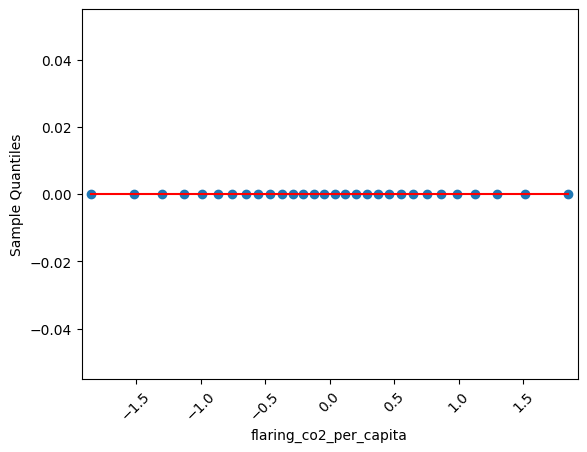

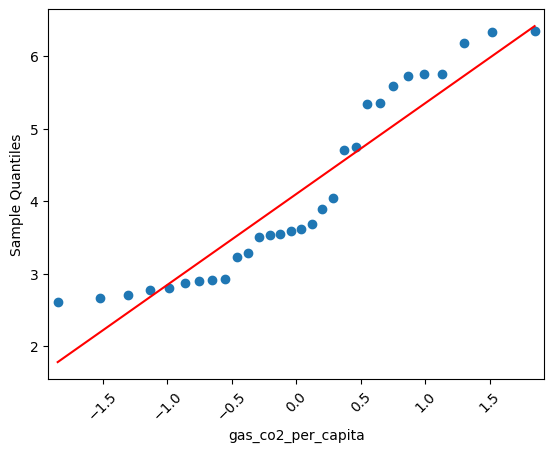

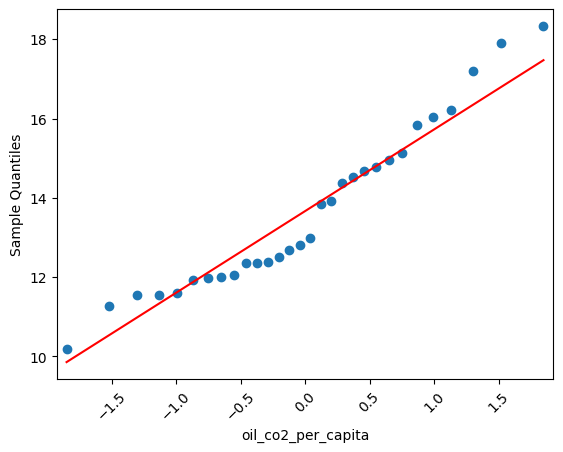

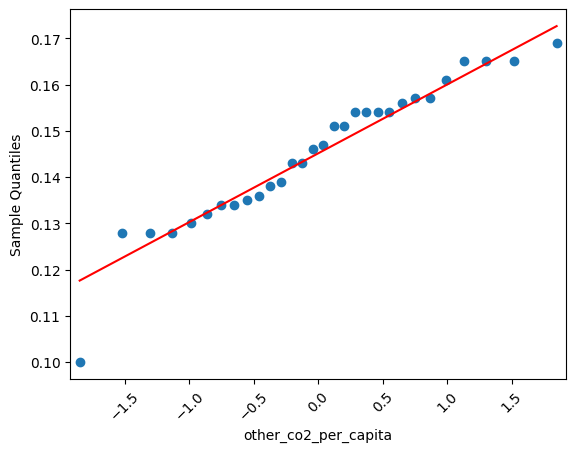

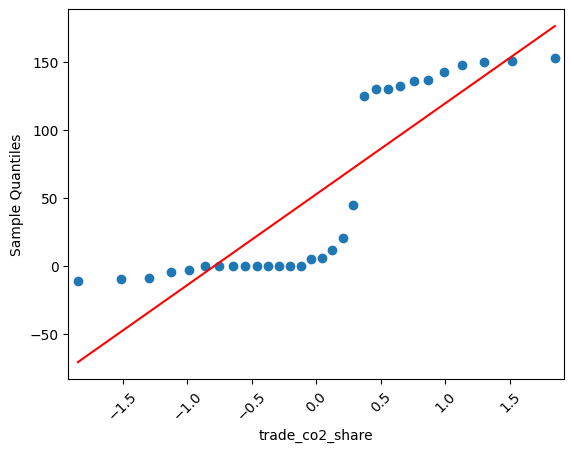

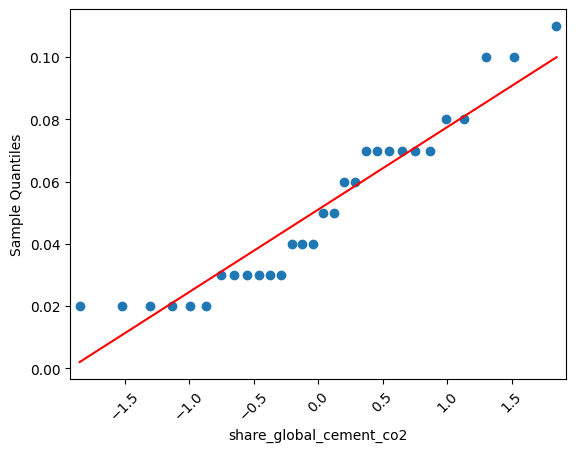

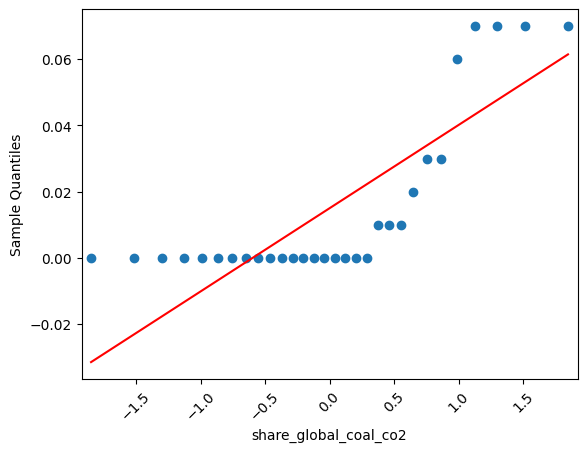

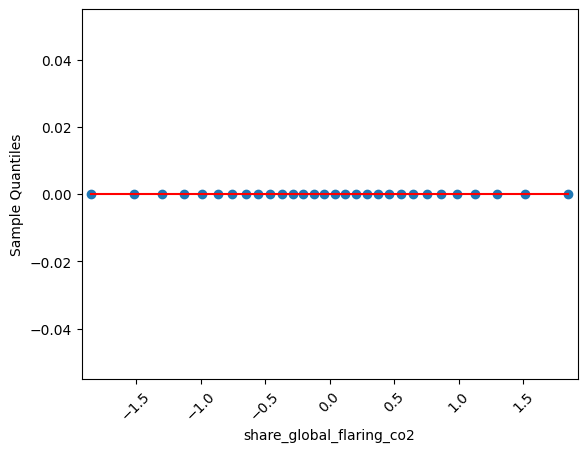

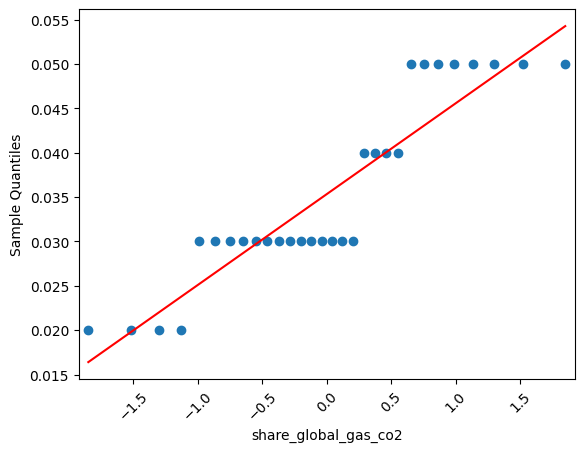

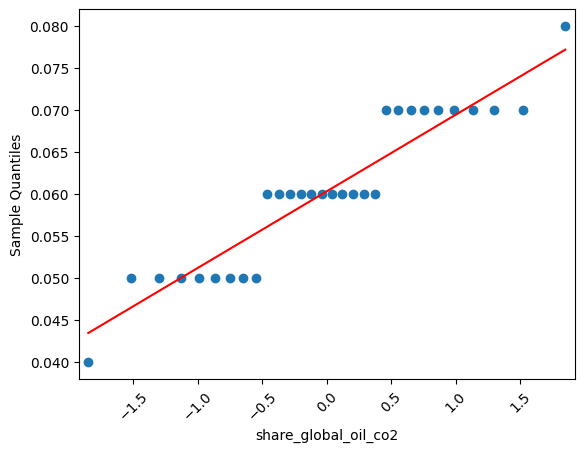

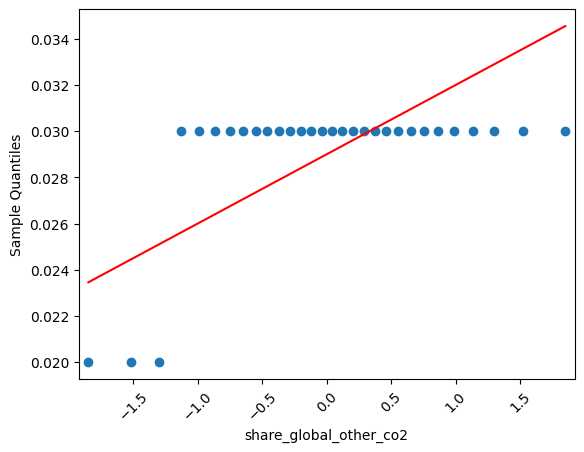

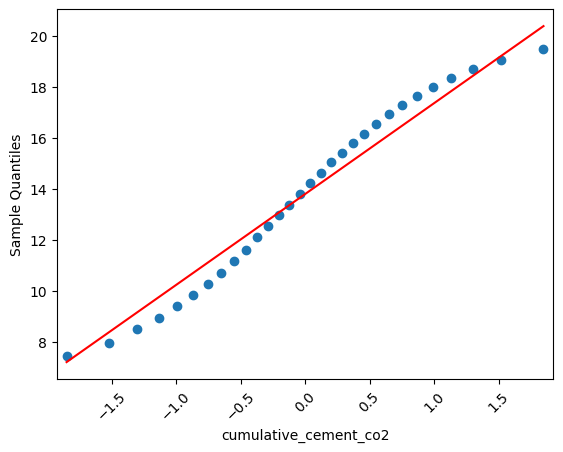

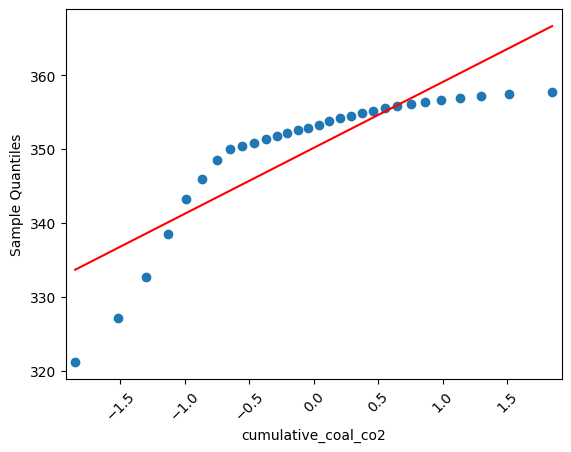

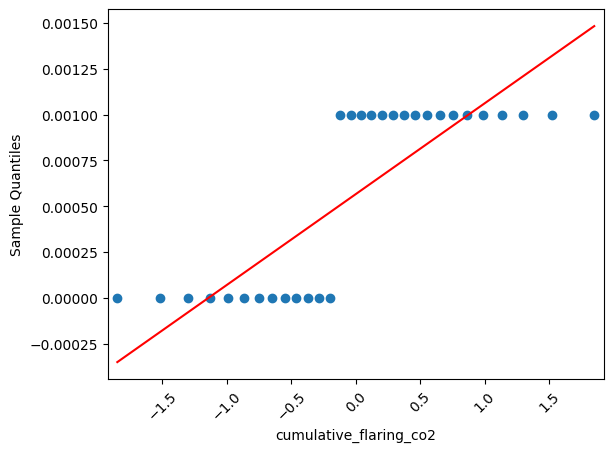

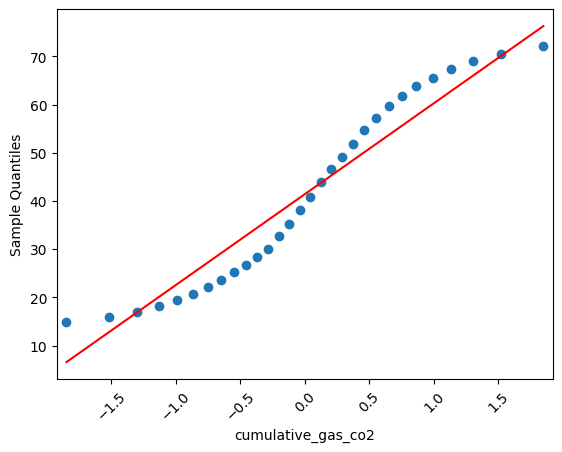

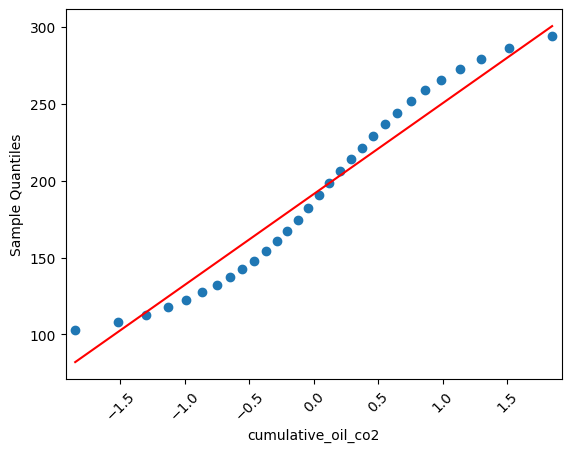

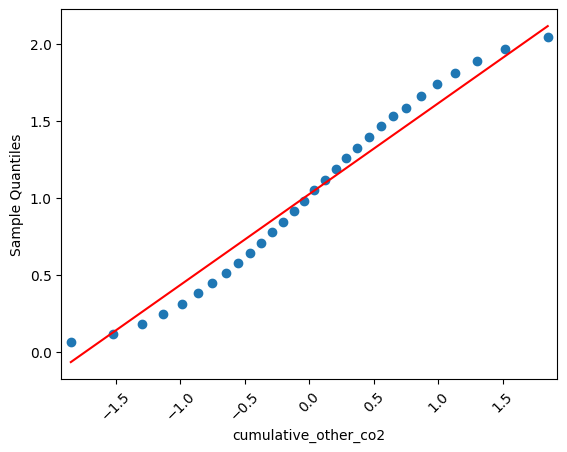

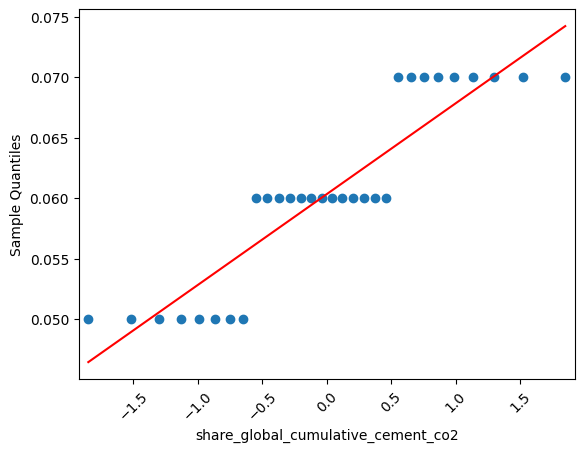

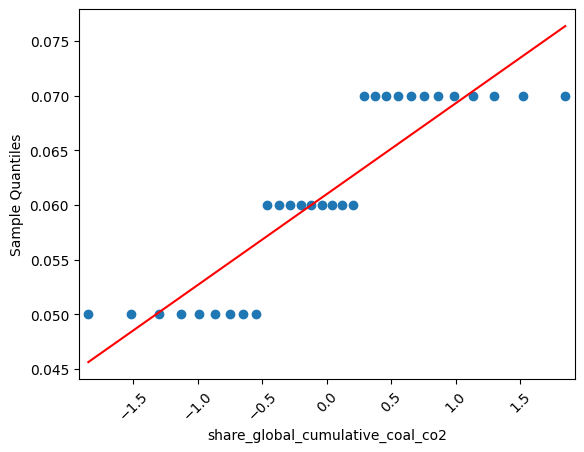

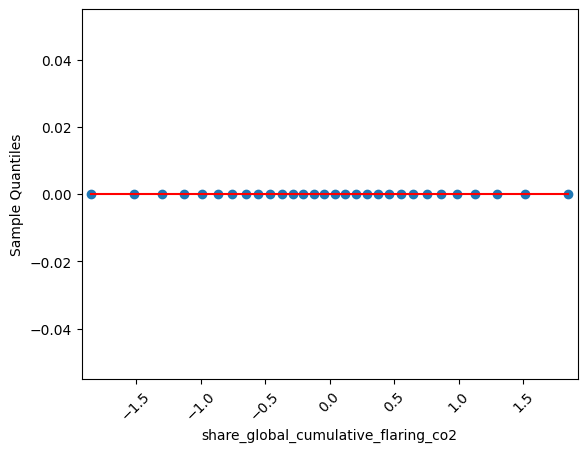

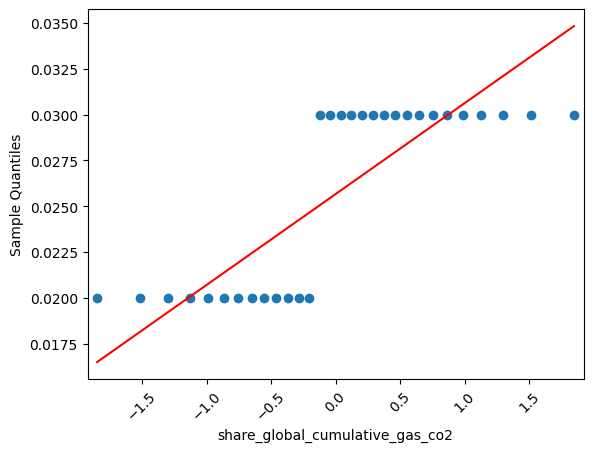

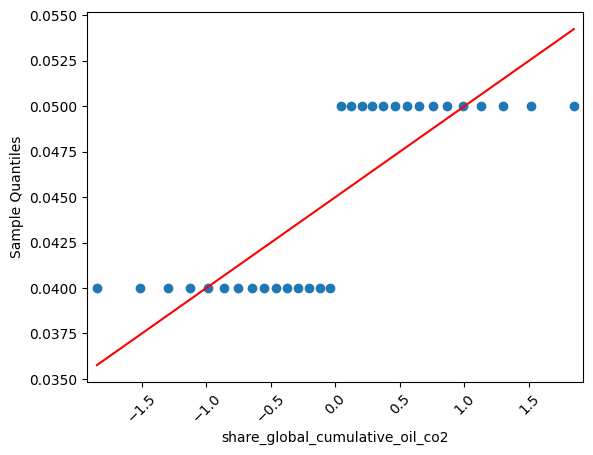

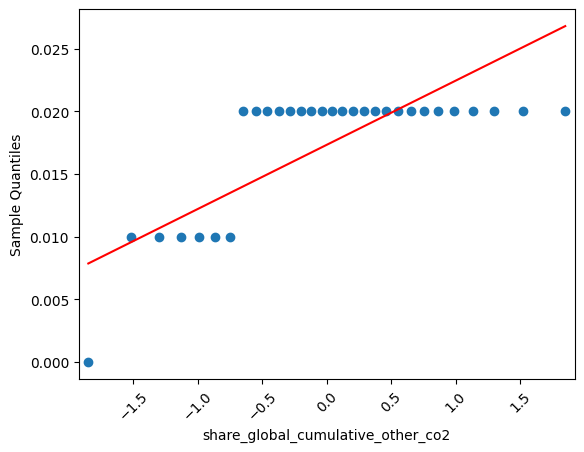

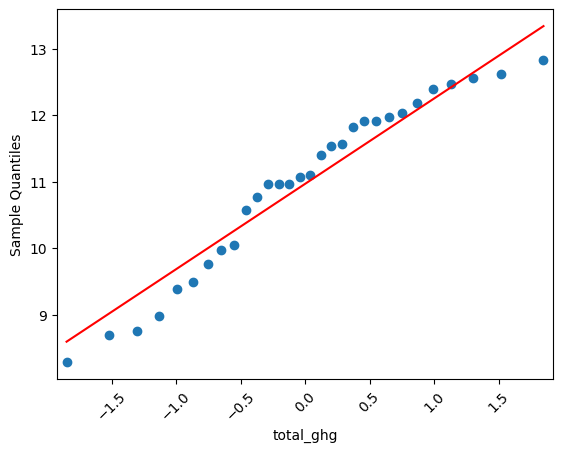

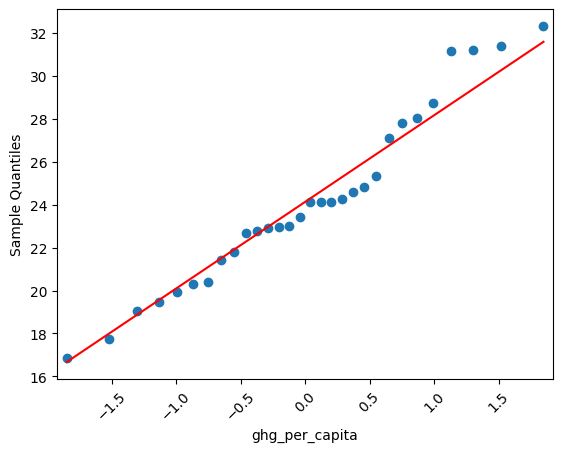

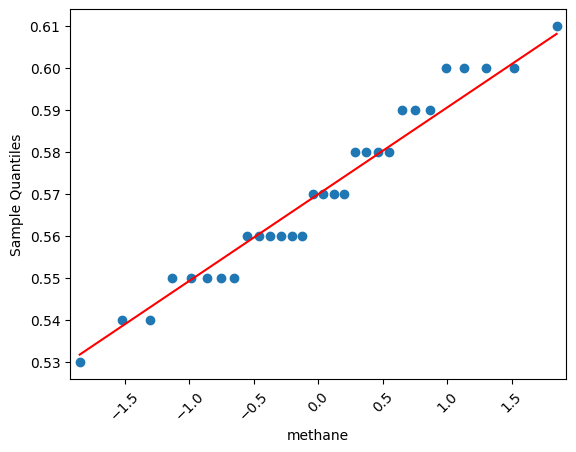

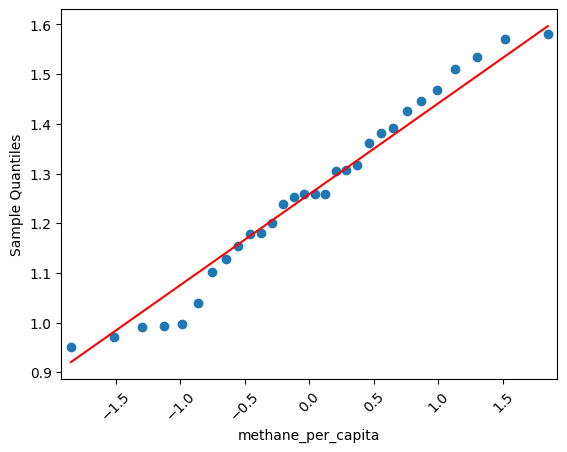

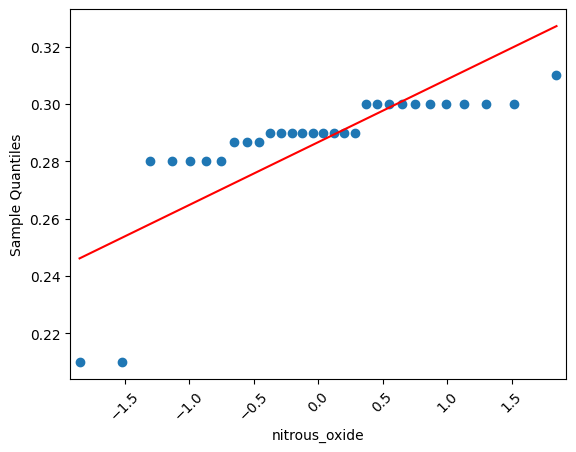

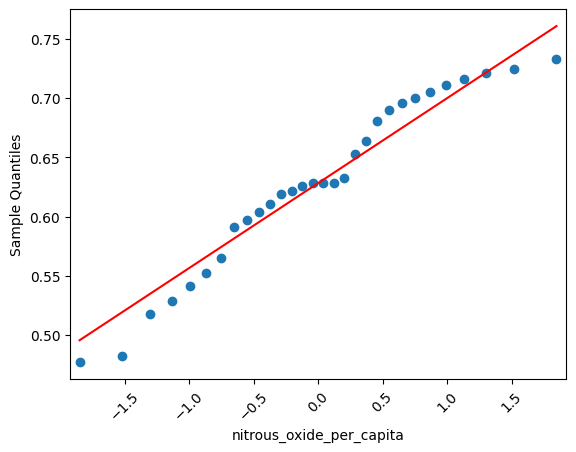

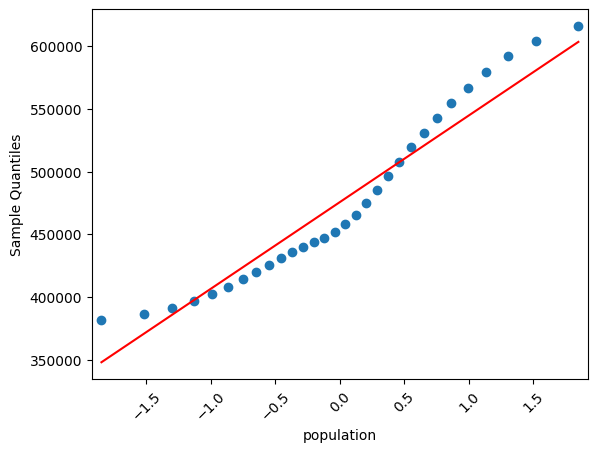

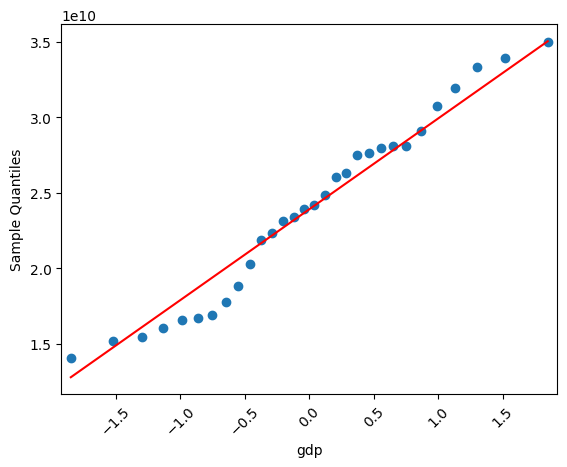

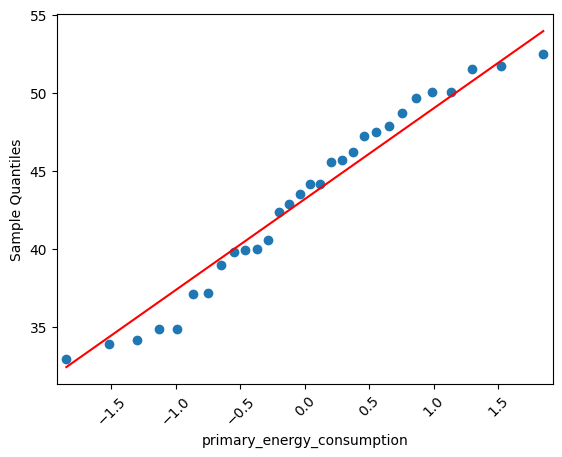

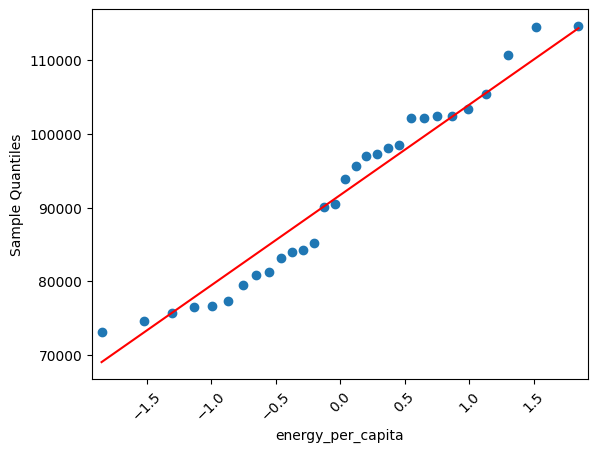

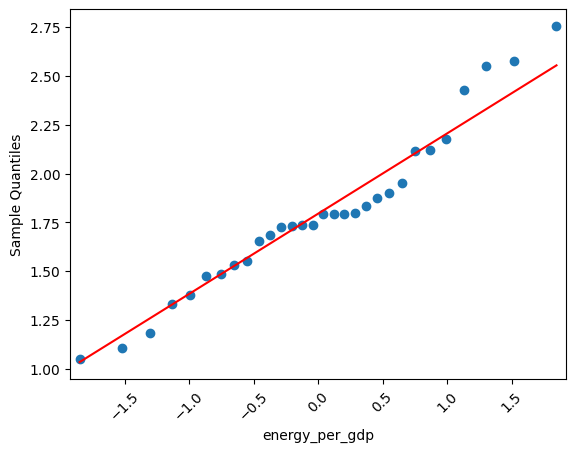

In [267]:
def qqplot_plot(df_input):
    for column in df_input:
        graph = df_input.loc[df_input[column].notnull(), column]
        sm.qqplot(graph, line='s')
        plt.xlabel(column)
        plt.xticks(rotation=45)
        pylab.show()

qqplot_plot(df_Lux)

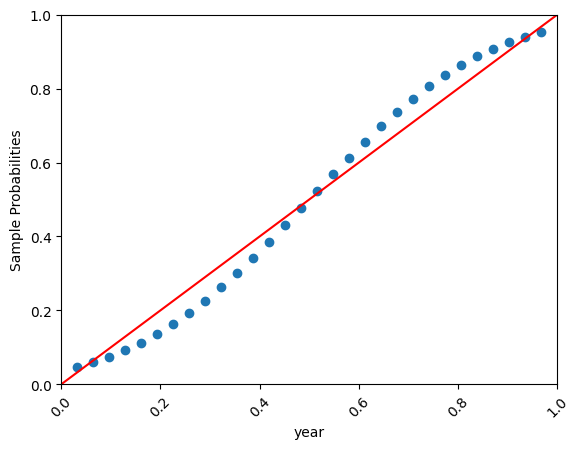

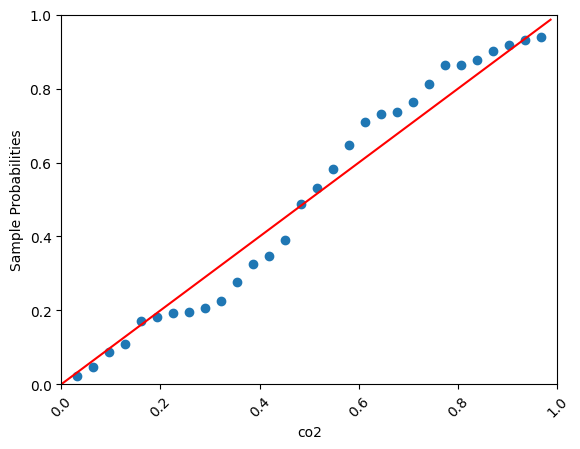

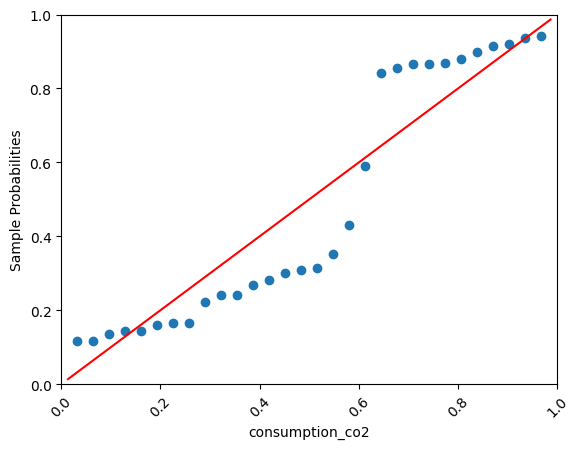

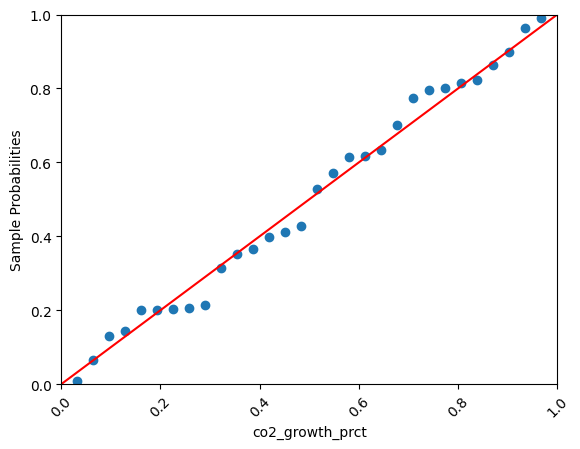

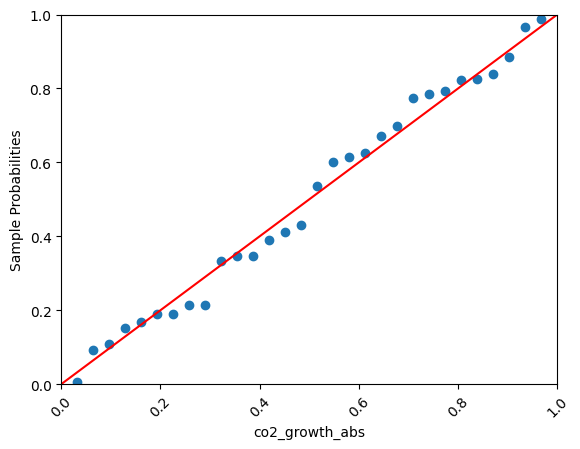

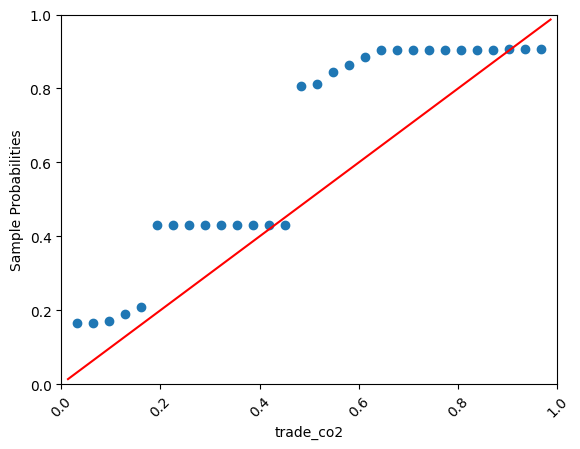

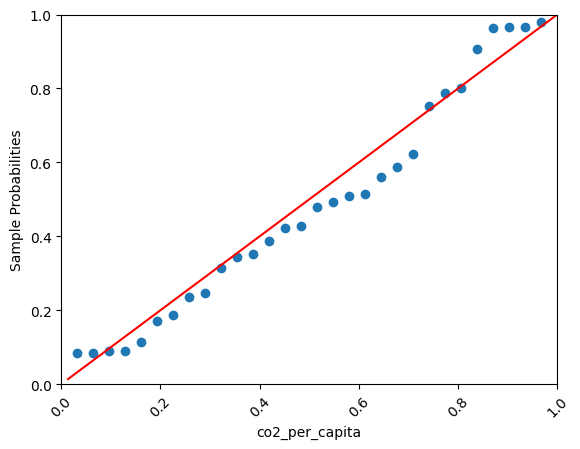

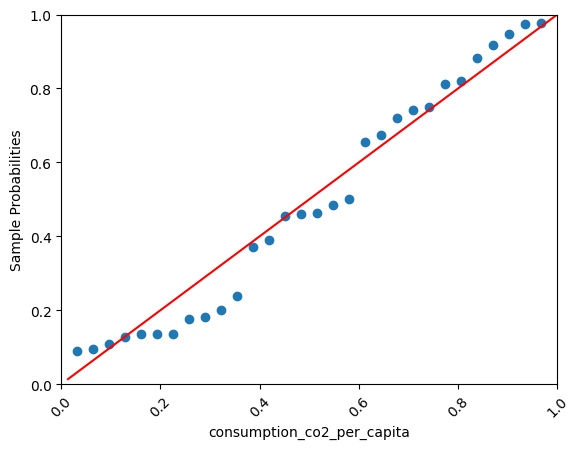

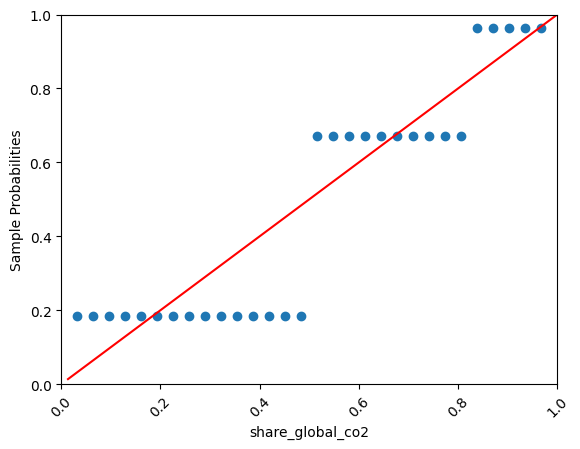

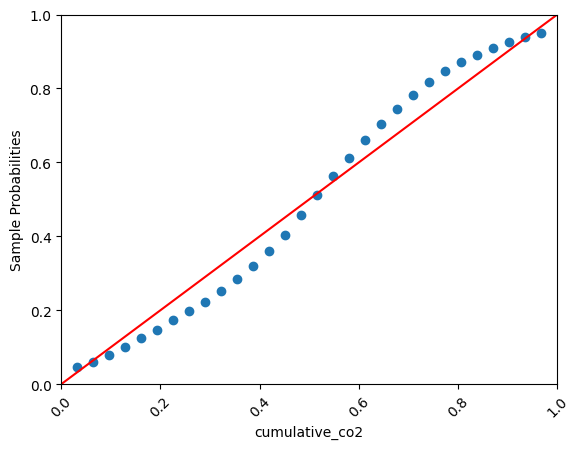

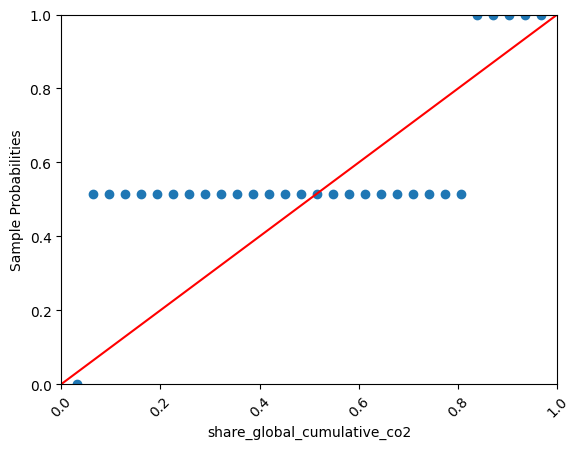

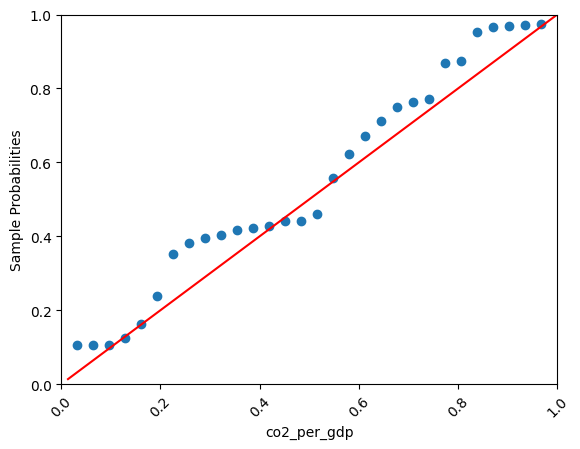

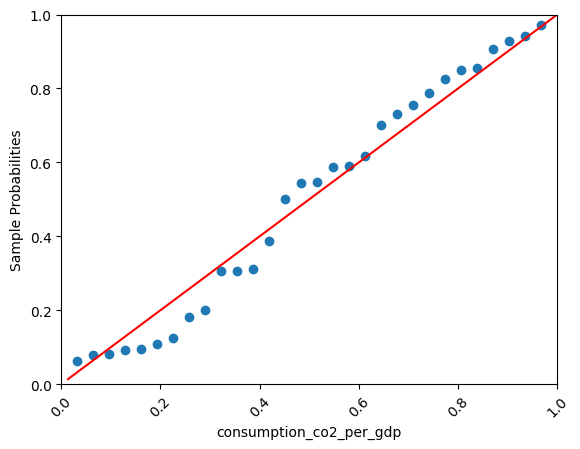

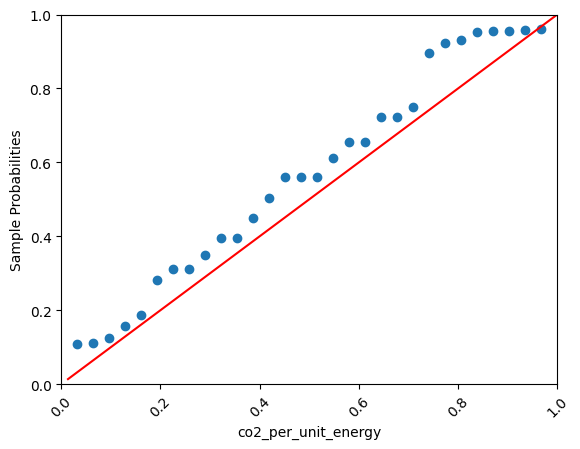

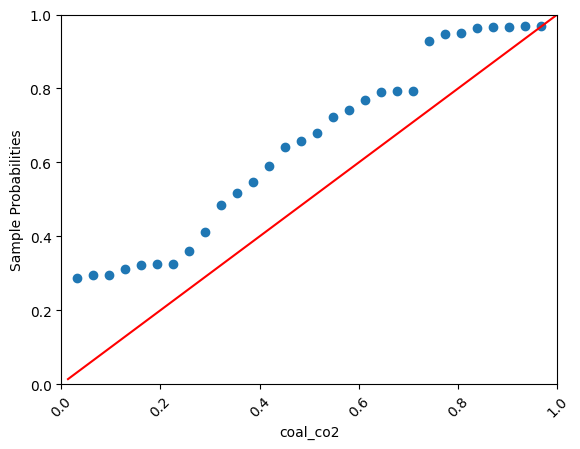

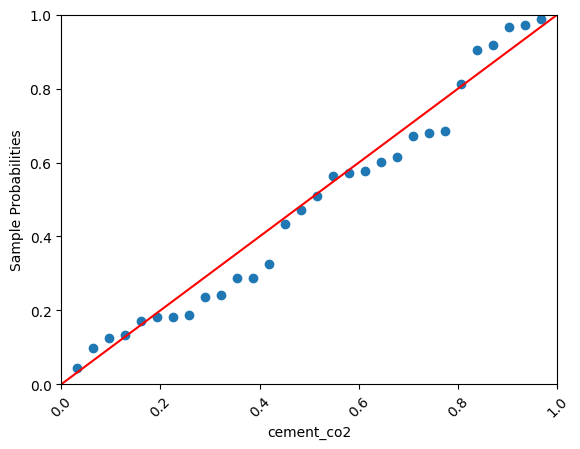

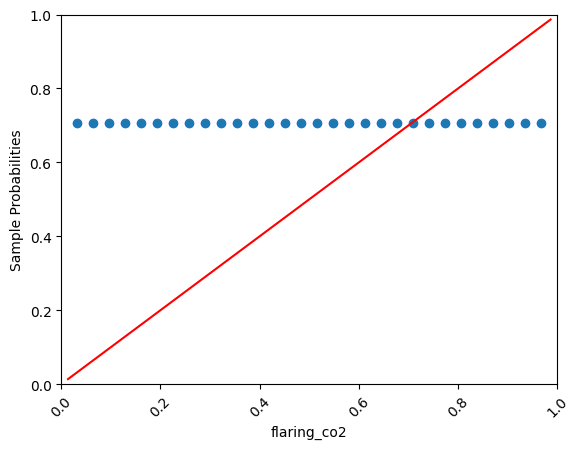

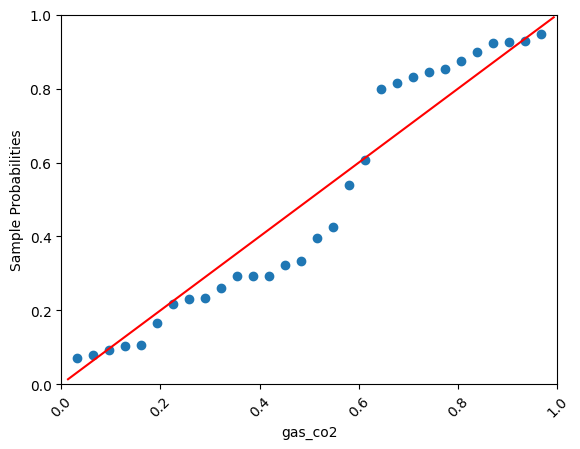

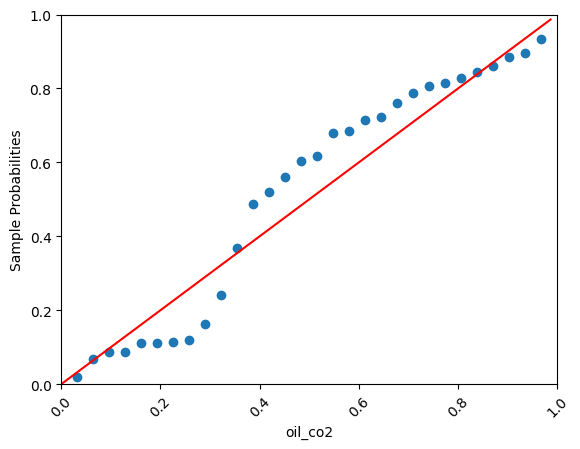

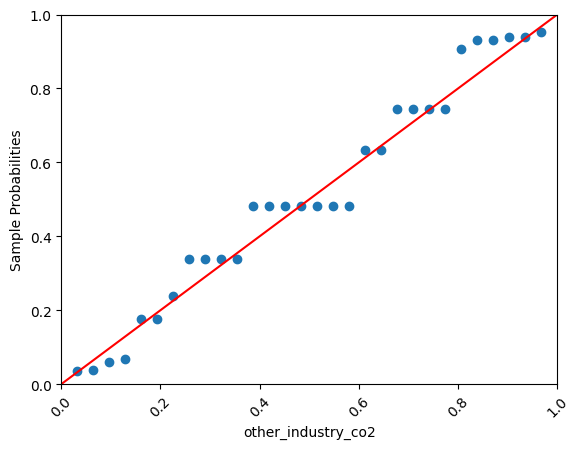

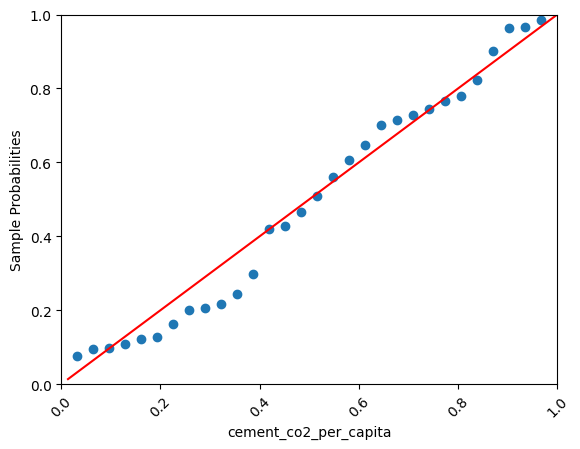

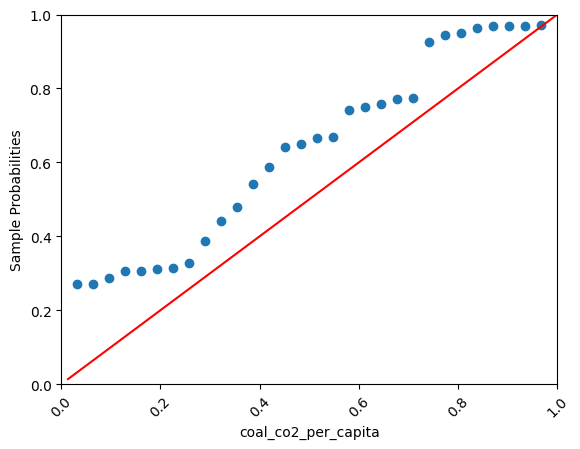

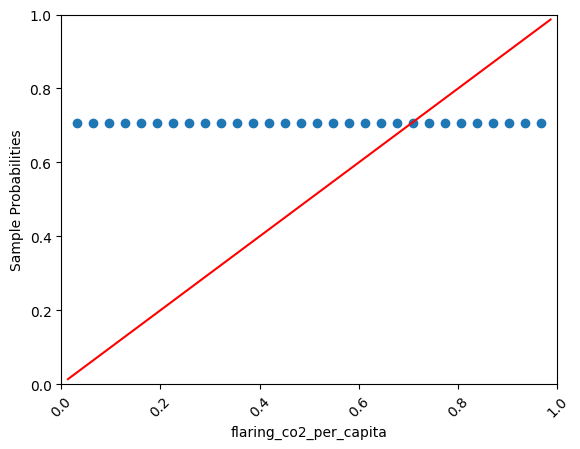

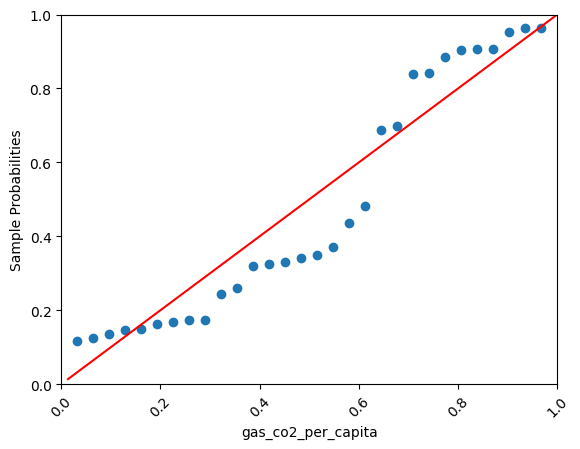

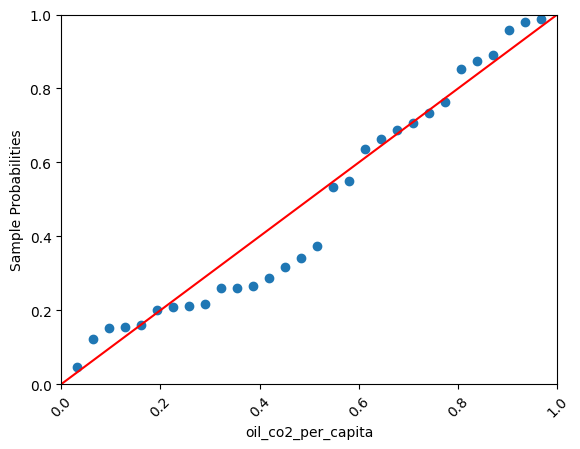

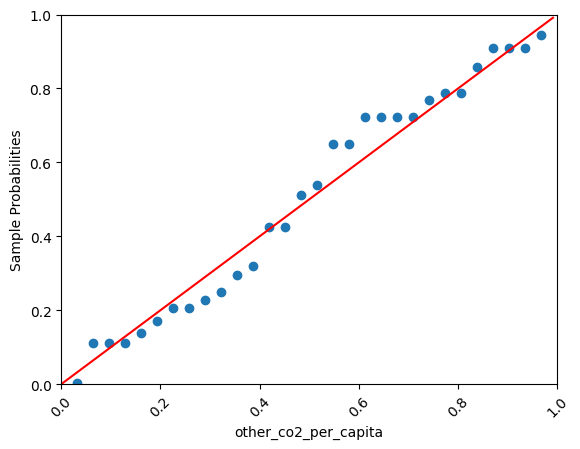

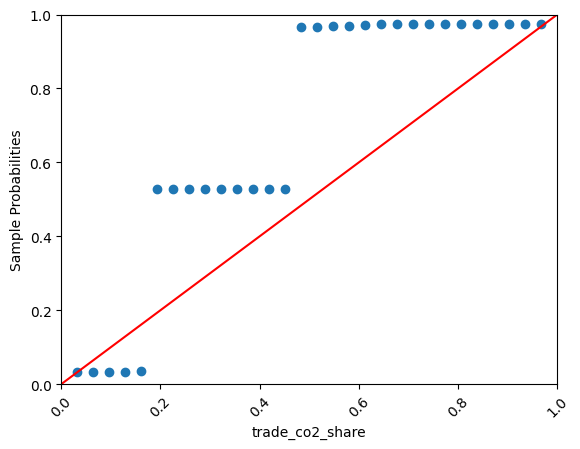

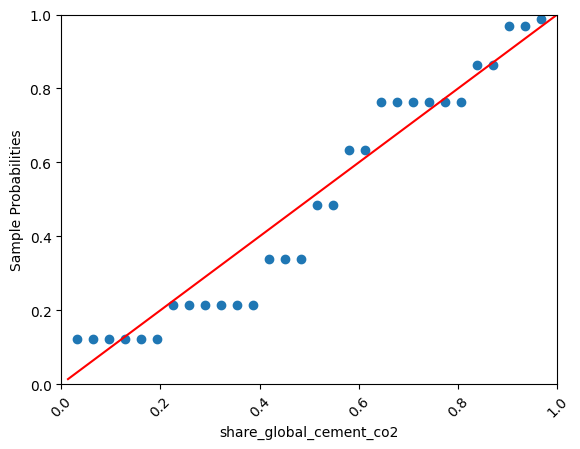

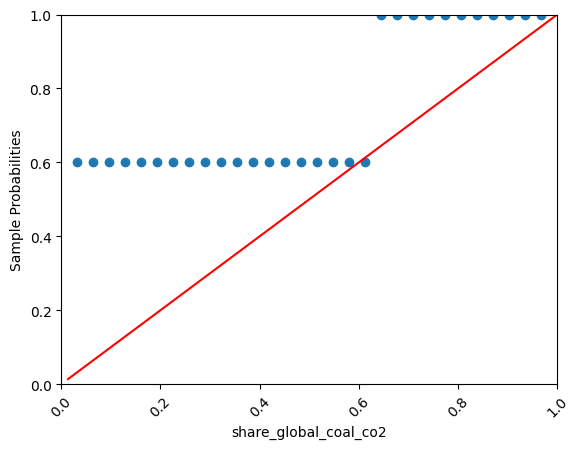

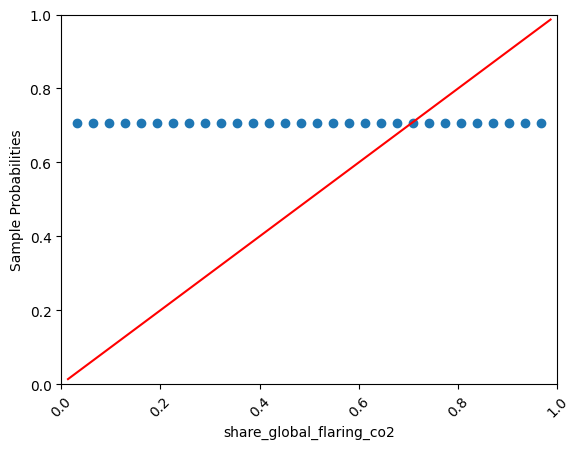

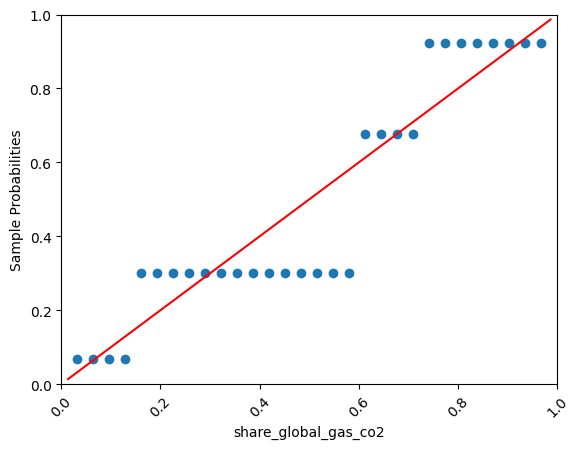

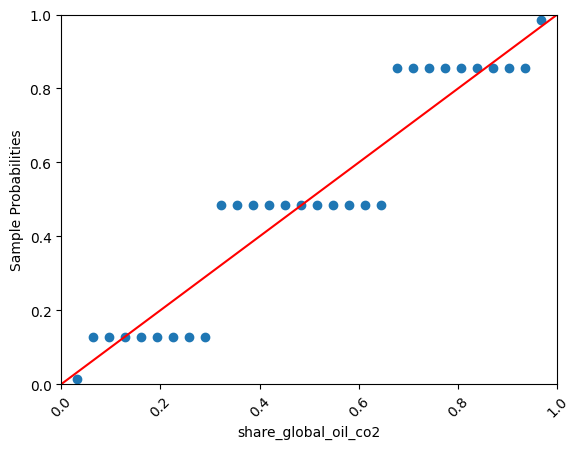

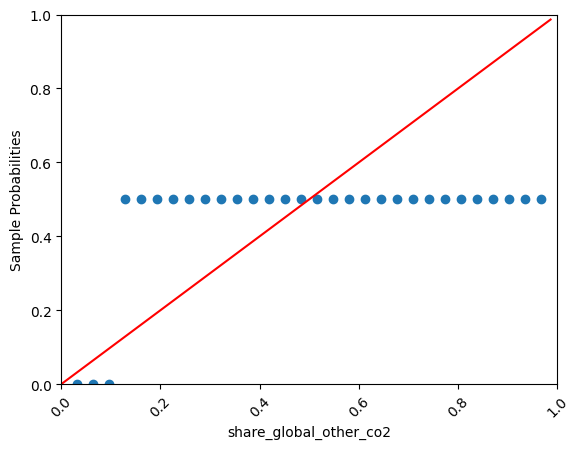

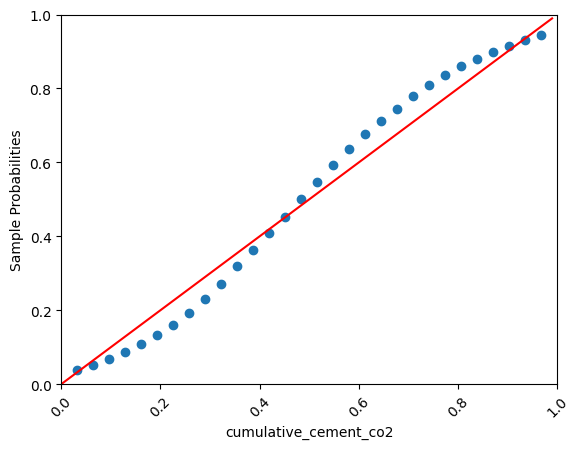

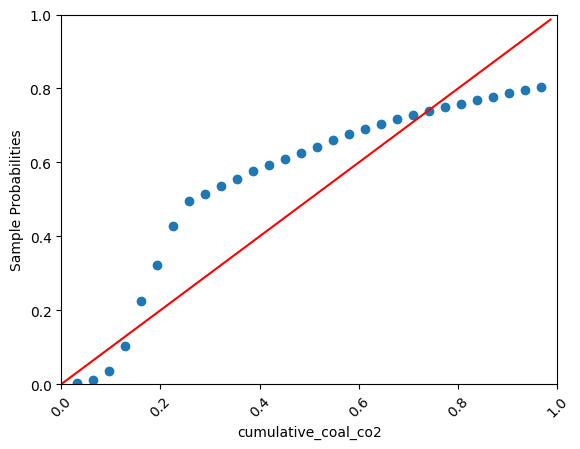

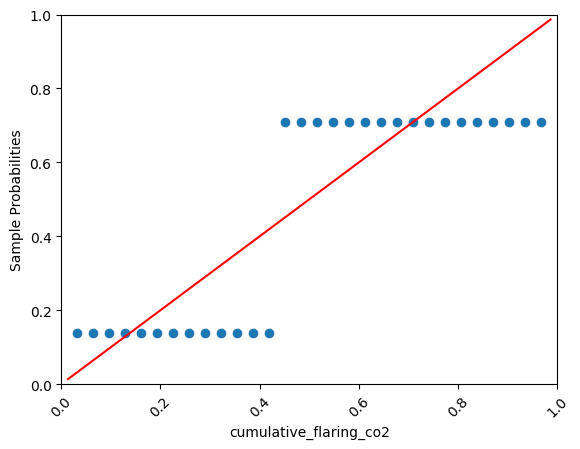

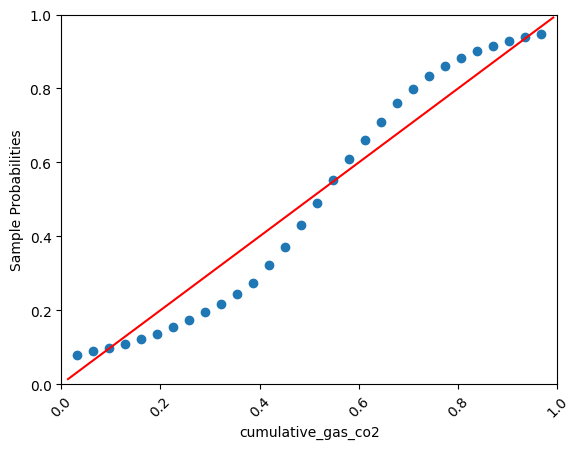

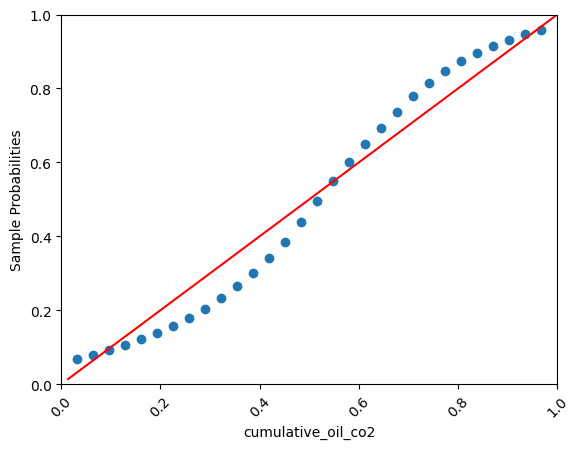

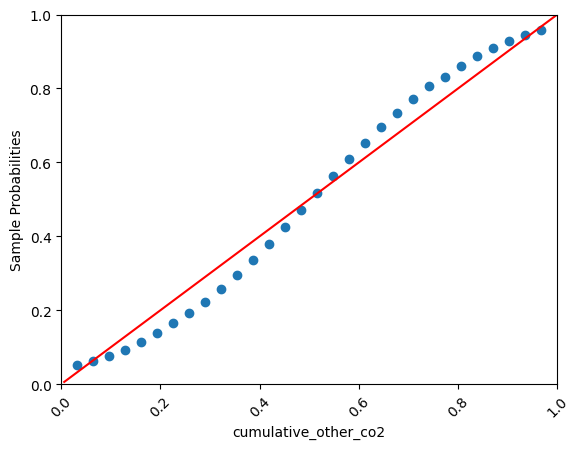

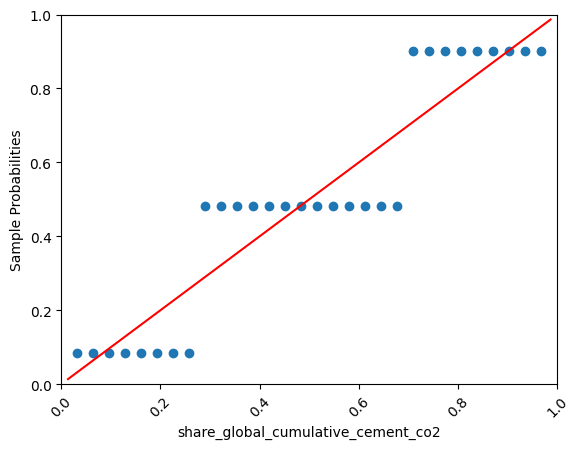

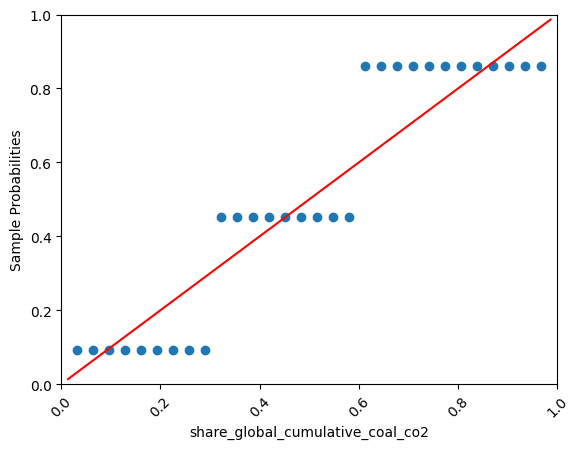

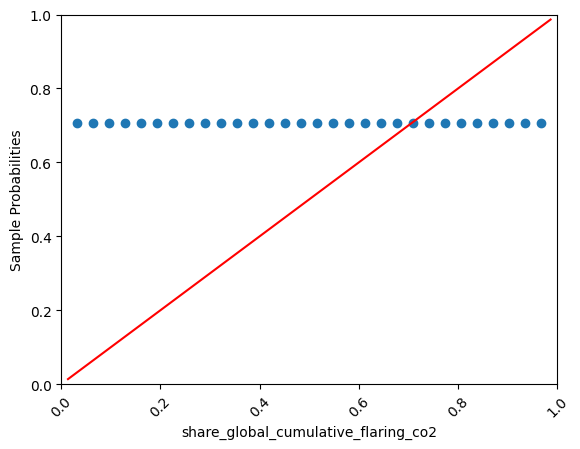

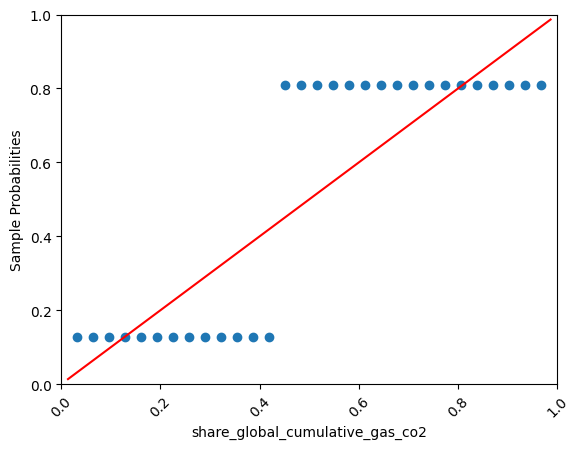

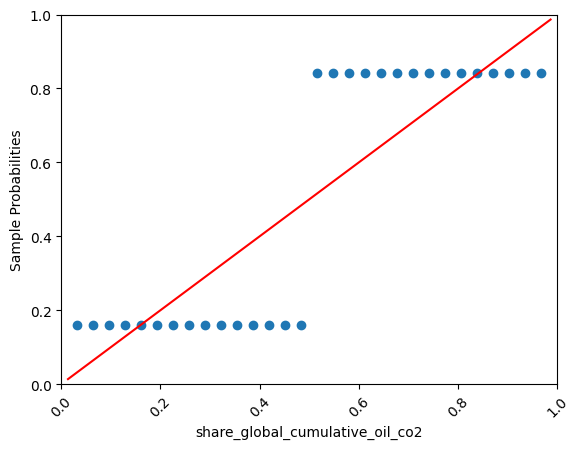

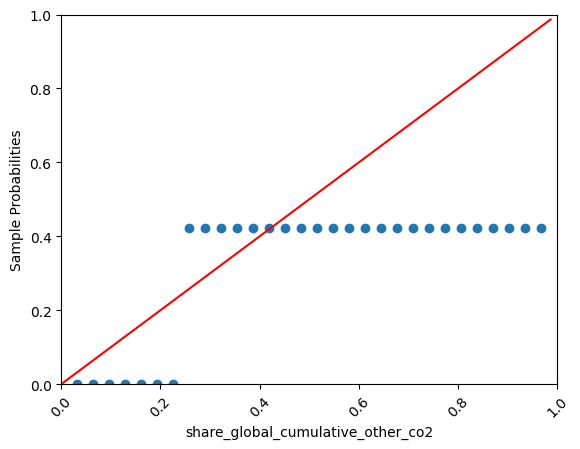

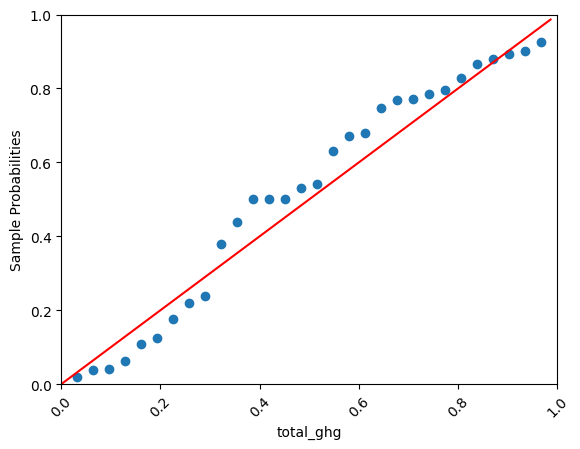

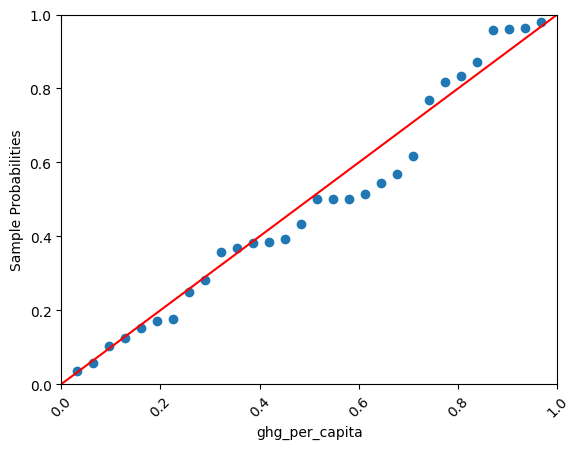

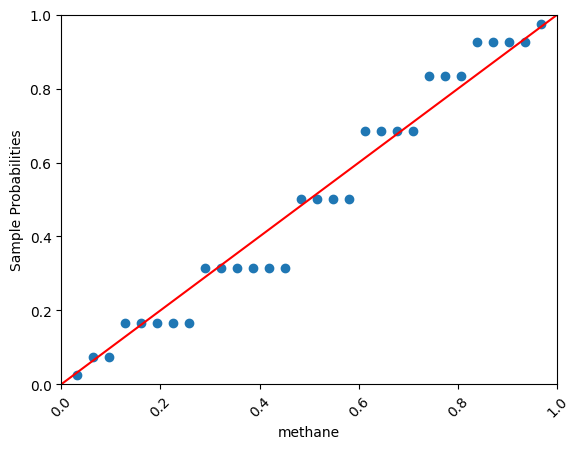

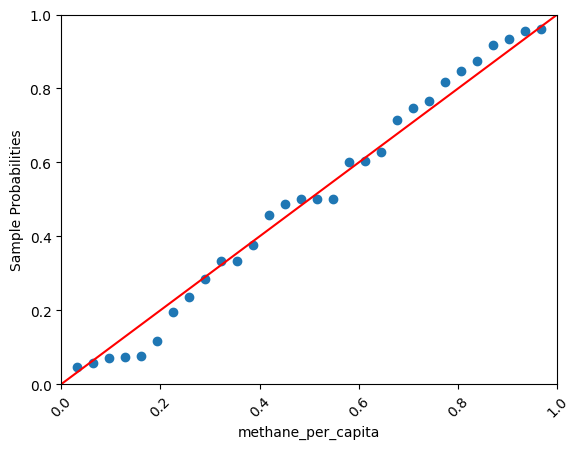

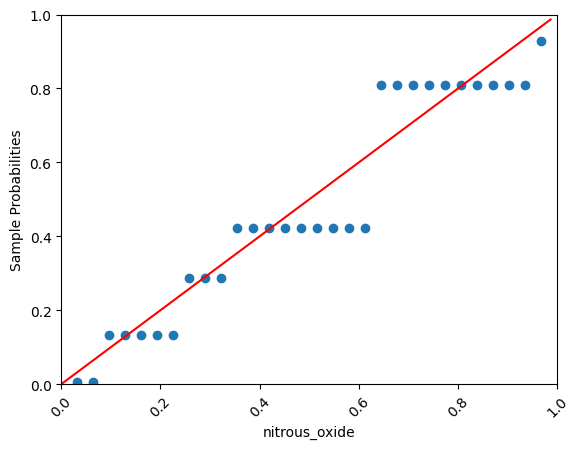

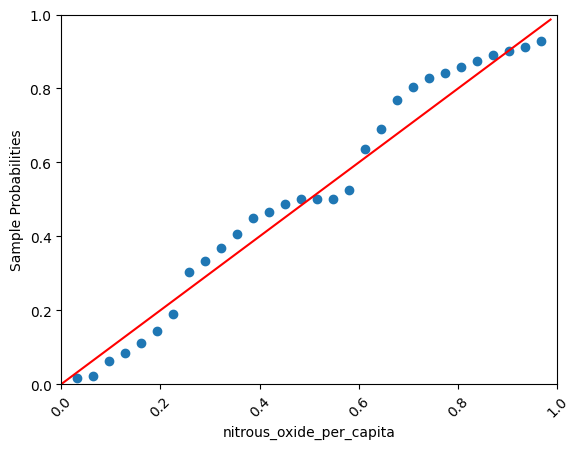

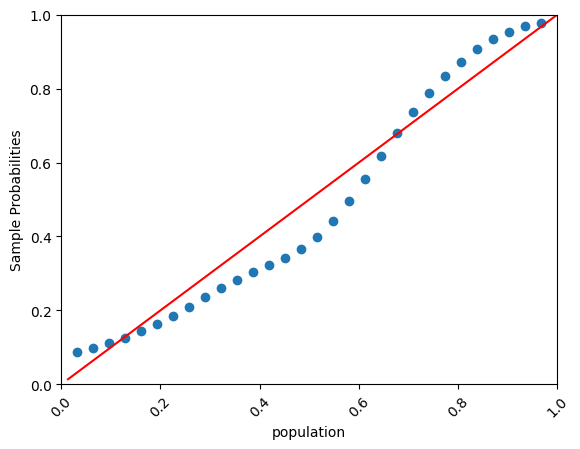

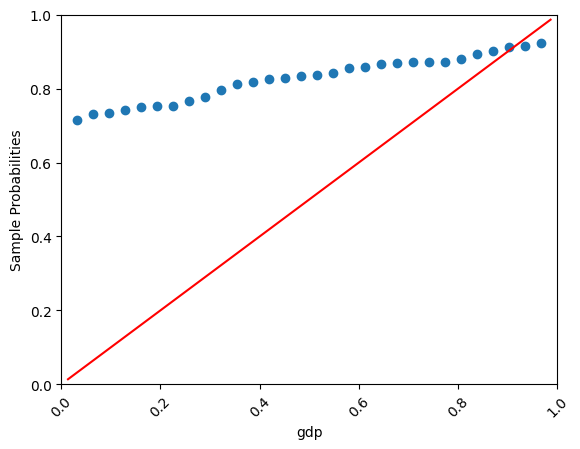

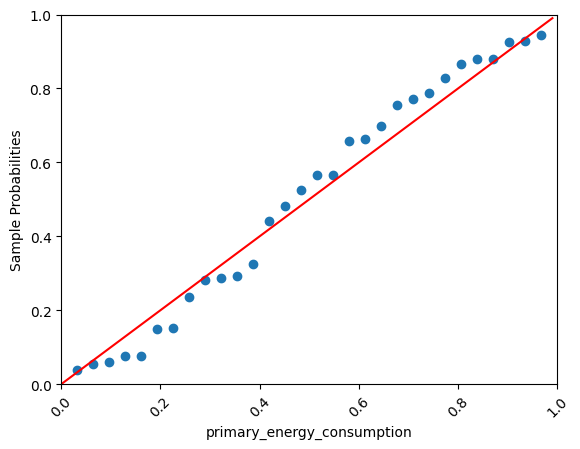

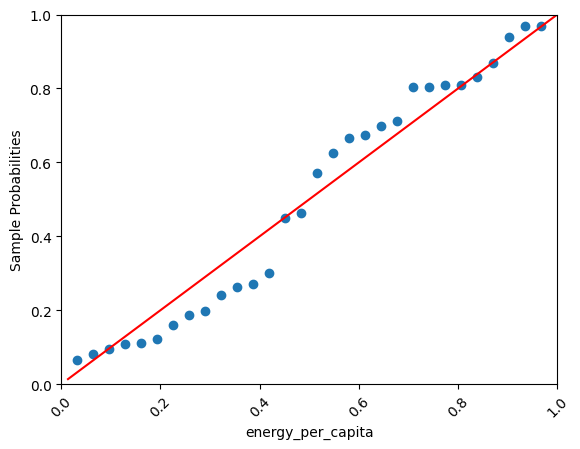

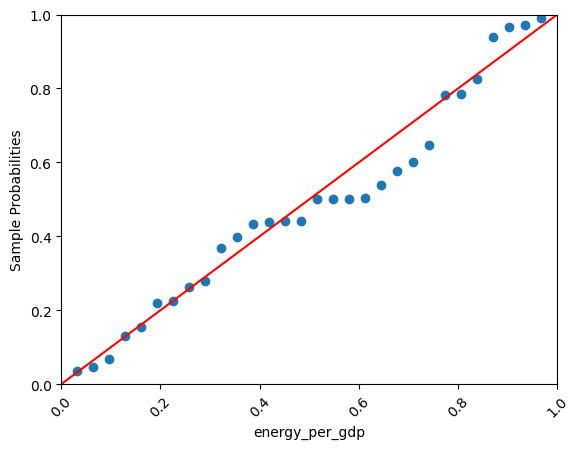

In [268]:
def ppplot_plot(df_input):
    for column in df_input:
        graph = df_input.loc[df_input[column].notnull(), column]
        pplot = sm.ProbPlot(graph, stats.t, fit=True)
        pplot.ppplot(line='45')
        plt.xlabel(column)
        plt.xticks(rotation=45)
        pylab.show()

ppplot_plot(df_Lux)

Test of Normality

In [269]:
Image(url='https://github.com/JanCinis/co2-emissions-analysis/blob/40e027e72307f976f680dcc775c1acda3a99d955/test_normality_SPSS.png?raw=true', width=500)

Conclusion: only 19 are normal out of 58

Z-score skewness & kurtosis

In [270]:
Image(url='https://github.com/JanCinis/co2-emissions-analysis/blob/main/z_score_skewness_kurtosis.png?raw=true', width=500)

### Conslusion:

###### Based on boxplot, histogram, bell curve shape, descriptive statistics, central tendency, Q-Q and P-P plots, Kolomogorov-Smirnov, Shapiro-Wilk, Z-score skewness and kurtosis results. For Luxembourg sample we can consider only the variables as normal:

###### <font color='yellow'> co2_growth_prct, cumulative_oil_co2, cumulative_cement_co2 </font>

### T-tests for variables with normal distribution

#### Independent Sample T-test

A two-sample t-test investigates whether the means of two independent samples differ from one another.

1-st sample: cumulativ production-based emission of CO2 for oil in Luxembourg

2-nd sample: cumulativ production-based emission of CO2 for cement in Luxembourg

---
H0: the mean of cumulativ production-based emission of CO2 is the same for oil and cement

H1: these mean values aren different

In [271]:
Image(url='https://github.com/JanCinis/co2-emissions-analysis/blob/main/independent_tt_cumulative_oil_cement_co2.png?raw=true', width=800)

Conclusion: statistic t = -16.1, pvalue < 0.05, we rejected null hypothesis, those are different distributions (their means differ)

#### Paired Sample T-test

A two-sample t-test investigates if there is difference between samples of the same group at the different points in time

1-st sample: percentage increase in CO2 emissions from 1990 to 2005

2-nd sample: percentage increase in CO2 emissions from 2006 to 2019

---
H0: the mean of produced-based emission of co2 is the same from 1990 to 2005 as the mean of produced-based emission from 2006 to 2019

H1: these mean values are different

In [272]:
Image(url='https://github.com/JanCinis/co2-emissions-analysis/blob/main/paired_TT_for_co2_growth_prct.png?raw=true', width=800)

Conclusion: statistic t = 1.1 < 1.6, pvalue > 0.05, CI crosses 0, the means of these distributions don't differ